In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import datetime
import transbigdata as tbd
import regex as re

In [3]:
import fiona
fiona.drvsupport.supported_drivers['KML'] = 'rw'

In [4]:
route =  r'../data/external/Ligne-101.kml'

In [5]:
linegstop = gpd.GeoDataFrame.from_file(route,driver='KML')
line = linegstop.iloc[0:1].copy()
stops = linegstop.drop([0])


In [6]:
line

,Name,Description,geometry
0,Ligne 101,,"LINESTRING (5.39210 36.18485, 5.39219 36.18577..."


<AxesSubplot:>

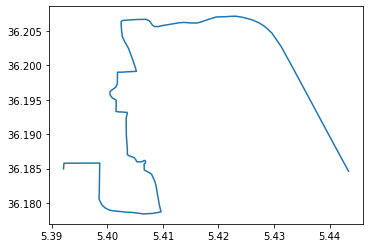

In [7]:
line.plot()

In [8]:
stops.head()

,Name,Description,geometry
1,GR,,POINT (5.39196 36.18542)
2,CFA01,,POINT (5.39497 36.18572)
3,CFA02,,POINT (5.39865 36.18503)
4,SAMU,,POINT (5.39862 36.18096)
5,MAHDI,,POINT (5.39999 36.17926)


<AxesSubplot:>

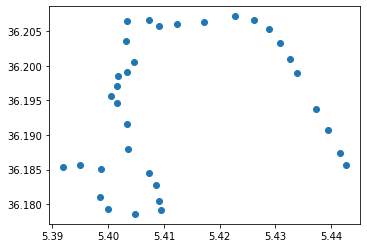

In [9]:
stops.plot()

In [10]:
stops['stopname'] = stops['Name']
stops = stops.drop(stops.columns[1],axis=1)
stops = stops.drop(stops.columns[0],axis=1)

In [11]:
stops['lon'] = stops.geometry.apply(lambda p: p.x)
stops['lat'] = stops.geometry.apply(lambda p: p.y)
stops['linename']="101"

In [12]:
stop=stops.loc[:,['linename','stopname','lat','lon','geometry']]
stop.head()

,linename,stopname,lat,lon,geometry
1,101,GR,36.185421,5.391961,POINT (5.39196 36.18542)
2,101,CFA01,36.185718,5.394972,POINT (5.39497 36.18572)
3,101,CFA02,36.185034,5.398654,POINT (5.39865 36.18503)
4,101,SAMU,36.180957,5.398621,POINT (5.39862 36.18096)
5,101,MAHDI,36.179260,5.399993,POINT (5.39999 36.17926)


In [13]:
import folium
from xml.dom import minidom

# Parse the KML file to extract the coordinates
kml = minidom.parse("../data/external/Ligne-101.kml")
coordinates = kml.getElementsByTagName("coordinates")[0].firstChild.nodeValue.strip().split("\n")

# Create a list of tuples for the coordinates
coords_list = []
for coord in coordinates:
    lat, lon = coord.split(",")
    coords_list.append((float(lon),float(lat)))

# Create a map centered on your city
map = folium.Map(location=[36.1943, 5.4192], zoom_start=14)

# Add the polyline to the map
folium.PolyLine(
    locations=coords_list,
    weight=3,
    color="blue",
    opacity=1,
).add_to(map)


# Read in your data
df = stops


# Create a feature group for your route
route_group = folium.FeatureGroup(name='Route')

# Loop through your data and add markers for each stop on the route
for index, row in df.iterrows():
    folium.Marker(
        location=[row['lat'], row['lon']],
        popup=row['stopname'],
        icon=folium.Icon(color='blue')
    ).add_to(route_group)

# Add the route group to the map
route_group.add_to(map)

# Create a feature group for your bus
bus_group = folium.FeatureGroup(name='Bus')

# Add a marker for your bus
folium.Marker(
    location=[5.439383	,36.190757],
    popup='Bus',
    icon=folium.Icon(color='red', icon='bus', prefix='fa')
).add_to(bus_group)

# Add the bus group to the map
bus_group.add_to(map)

# Add a layer control to the map
folium.LayerControl().add_to(map)
map
# Save the map as an HTML file
#map.save('route_map.html')


In [14]:
BUS_GPS= pd.read_csv(r'../data/interim/DATARAW.csv')
#Convert the time column to datetime type
BUS_GPS

,ID,Time,Longitude,Latitude,Speed,Attributes
0,19003,2023-02-16 05:59:39,5.460321,36.177352,1.1 km/h,distance=45.67 totalDistance=3587390.94 moti...
1,19003,2023-02-16 05:59:42,5.460317,36.177343,1.6 km/h,alarm=vibration distance=1.07 totalDistance=...
2,19003,2023-02-16 05:59:49,5.460310,36.177252,3.3 km/h,distance=10.13 totalDistance=3587402.14 moti...
3,19003,2023-02-16 05:59:59,5.460355,36.177267,0.0 km/h,distance=4.42 totalDistance=3587406.56 motio...
4,19003,2023-02-16 06:00:04,5.460362,36.177269,6.4 km/h,distance=0.7 totalDistance=3587407.26 motion...
...,...,...,...,...,...,...
1881323,19008,2023-02-15 22:59:17,5.460155,36.176907,0.0 km/h,distance=0.0 totalDistance=3757274.36 motion...
1881324,19008,2023-02-15 22:59:27,5.460155,36.176907,0.0 km/h,distance=0.0 totalDistance=3757274.36 motion...
1881325,19008,2023-02-15 22:59:37,5.460155,36.176907,0.0 km/h,distance=0.0 totalDistance=3757274.36 motion...
1881326,19008,2023-02-15 22:59:47,5.460155,36.176907,0.0 km/h,distance=0.0 totalDistance=3757274.36 motion...


In [16]:
BUS_GPS=BUS_GPS.loc[0:6000,:]

In [17]:
BUS_GPS["GPSDateTime"]=BUS_GPS["Time"]
BUS_GPS["GPSDateTime"]=pd.to_datetime(BUS_GPS["GPSDateTime"])
BUS_GPS

,ID,Time,Longitude,Latitude,Speed,Attributes,GPSDateTime
0,19003,2023-02-16 05:59:39,5.460321,36.177352,1.1 km/h,distance=45.67 totalDistance=3587390.94 moti...,2023-02-16 05:59:39
1,19003,2023-02-16 05:59:42,5.460317,36.177343,1.6 km/h,alarm=vibration distance=1.07 totalDistance=...,2023-02-16 05:59:42
2,19003,2023-02-16 05:59:49,5.460310,36.177252,3.3 km/h,distance=10.13 totalDistance=3587402.14 moti...,2023-02-16 05:59:49
3,19003,2023-02-16 05:59:59,5.460355,36.177267,0.0 km/h,distance=4.42 totalDistance=3587406.56 motio...,2023-02-16 05:59:59
4,19003,2023-02-16 06:00:04,5.460362,36.177269,6.4 km/h,distance=0.7 totalDistance=3587407.26 motion...,2023-02-16 06:00:04
...,...,...,...,...,...,...,...
5996,19003,2023-02-16 20:03:43,5.460381,36.177363,0.0 km/h,distance=0.0 totalDistance=3724091.31 motion...,2023-02-16 20:03:43
5997,19003,2023-02-16 20:03:53,5.460381,36.177363,0.0 km/h,distance=0.0 totalDistance=3724091.31 motion...,2023-02-16 20:03:53
5998,19003,2023-02-16 20:04:03,5.460381,36.177363,0.0 km/h,distance=0.0 totalDistance=3724091.31 motion...,2023-02-16 20:04:03
5999,19003,2023-02-16 20:04:13,5.460381,36.177363,0.0 km/h,distance=0.0 totalDistance=3724091.31 motion...,2023-02-16 20:04:13


In [18]:
BUS_GPS['ID'].unique()

array([19003])

In [19]:
#Convert coordinates
BUS_GPS['lon']=BUS_GPS['Longitude']
BUS_GPS['lat'] = BUS_GPS['Latitude']
BUS_GPS.head(5)

,ID,Time,Longitude,Latitude,Speed,Attributes,GPSDateTime,lon,lat
0,19003,2023-02-16 05:59:39,5.460321,36.177352,1.1 km/h,distance=45.67 totalDistance=3587390.94 moti...,2023-02-16 05:59:39,5.460321,36.177352
1,19003,2023-02-16 05:59:42,5.460317,36.177343,1.6 km/h,alarm=vibration distance=1.07 totalDistance=...,2023-02-16 05:59:42,5.460317,36.177343
2,19003,2023-02-16 05:59:49,5.460310,36.177252,3.3 km/h,distance=10.13 totalDistance=3587402.14 moti...,2023-02-16 05:59:49,5.460310,36.177252
3,19003,2023-02-16 05:59:59,5.460355,36.177267,0.0 km/h,distance=4.42 totalDistance=3587406.56 motio...,2023-02-16 05:59:59,5.460355,36.177267
4,19003,2023-02-16 06:00:04,5.460362,36.177269,6.4 km/h,distance=0.7 totalDistance=3587407.26 motion...,2023-02-16 06:00:04,5.460362,36.177269


In [20]:
BUS_GPS['VehicleId']=BUS_GPS['ID']


In [21]:
BUS_GPS['Attributes'] = BUS_GPS['Attributes'].str.replace(r'alarm=vibration  ', '')
BUS_GPS['Attributes'] = BUS_GPS['Attributes'].str.replace(r'alarm=lowBattery  ', '')
BUS_GPS['Attributes'] = BUS_GPS['Attributes'].str.replace(r'alarm=powerCut  ', '')

In [22]:
BUS_GPS

,ID,Time,Longitude,Latitude,Speed,Attributes,GPSDateTime,lon,lat,VehicleId
0,19003,2023-02-16 05:59:39,5.460321,36.177352,1.1 km/h,distance=45.67 totalDistance=3587390.94 moti...,2023-02-16 05:59:39,5.460321,36.177352,19003
1,19003,2023-02-16 05:59:42,5.460317,36.177343,1.6 km/h,distance=1.07 totalDistance=3587392.01 motio...,2023-02-16 05:59:42,5.460317,36.177343,19003
2,19003,2023-02-16 05:59:49,5.460310,36.177252,3.3 km/h,distance=10.13 totalDistance=3587402.14 moti...,2023-02-16 05:59:49,5.460310,36.177252,19003
3,19003,2023-02-16 05:59:59,5.460355,36.177267,0.0 km/h,distance=4.42 totalDistance=3587406.56 motio...,2023-02-16 05:59:59,5.460355,36.177267,19003
4,19003,2023-02-16 06:00:04,5.460362,36.177269,6.4 km/h,distance=0.7 totalDistance=3587407.26 motion...,2023-02-16 06:00:04,5.460362,36.177269,19003
...,...,...,...,...,...,...,...,...,...,...
5996,19003,2023-02-16 20:03:43,5.460381,36.177363,0.0 km/h,distance=0.0 totalDistance=3724091.31 motion...,2023-02-16 20:03:43,5.460381,36.177363,19003
5997,19003,2023-02-16 20:03:53,5.460381,36.177363,0.0 km/h,distance=0.0 totalDistance=3724091.31 motion...,2023-02-16 20:03:53,5.460381,36.177363,19003
5998,19003,2023-02-16 20:04:03,5.460381,36.177363,0.0 km/h,distance=0.0 totalDistance=3724091.31 motion...,2023-02-16 20:04:03,5.460381,36.177363,19003
5999,19003,2023-02-16 20:04:13,5.460381,36.177363,0.0 km/h,distance=0.0 totalDistance=3724091.31 motion...,2023-02-16 20:04:13,5.460381,36.177363,19003


In [23]:
BUS_GPS[['DistanceGap','totaldistance','motion']] =BUS_GPS['Attributes'].str.split('  ', expand=True)

In [24]:
BUS_GPS

,ID,Time,Longitude,Latitude,Speed,Attributes,GPSDateTime,lon,lat,VehicleId,DistanceGap,totaldistance,motion
0,19003,2023-02-16 05:59:39,5.460321,36.177352,1.1 km/h,distance=45.67 totalDistance=3587390.94 moti...,2023-02-16 05:59:39,5.460321,36.177352,19003,distance=45.67,totalDistance=3587390.94,motion=true
1,19003,2023-02-16 05:59:42,5.460317,36.177343,1.6 km/h,distance=1.07 totalDistance=3587392.01 motio...,2023-02-16 05:59:42,5.460317,36.177343,19003,distance=1.07,totalDistance=3587392.01,motion=true
2,19003,2023-02-16 05:59:49,5.460310,36.177252,3.3 km/h,distance=10.13 totalDistance=3587402.14 moti...,2023-02-16 05:59:49,5.460310,36.177252,19003,distance=10.13,totalDistance=3587402.14,motion=true
3,19003,2023-02-16 05:59:59,5.460355,36.177267,0.0 km/h,distance=4.42 totalDistance=3587406.56 motio...,2023-02-16 05:59:59,5.460355,36.177267,19003,distance=4.42,totalDistance=3587406.56,motion=false
4,19003,2023-02-16 06:00:04,5.460362,36.177269,6.4 km/h,distance=0.7 totalDistance=3587407.26 motion...,2023-02-16 06:00:04,5.460362,36.177269,19003,distance=0.7,totalDistance=3587407.26,motion=true
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5996,19003,2023-02-16 20:03:43,5.460381,36.177363,0.0 km/h,distance=0.0 totalDistance=3724091.31 motion...,2023-02-16 20:03:43,5.460381,36.177363,19003,distance=0.0,totalDistance=3724091.31,motion=false
5997,19003,2023-02-16 20:03:53,5.460381,36.177363,0.0 km/h,distance=0.0 totalDistance=3724091.31 motion...,2023-02-16 20:03:53,5.460381,36.177363,19003,distance=0.0,totalDistance=3724091.31,motion=false
5998,19003,2023-02-16 20:04:03,5.460381,36.177363,0.0 km/h,distance=0.0 totalDistance=3724091.31 motion...,2023-02-16 20:04:03,5.460381,36.177363,19003,distance=0.0,totalDistance=3724091.31,motion=false
5999,19003,2023-02-16 20:04:13,5.460381,36.177363,0.0 km/h,distance=0.0 totalDistance=3724091.31 motion...,2023-02-16 20:04:13,5.460381,36.177363,19003,distance=0.0,totalDistance=3724091.31,motion=false


In [25]:
BUS_GPS['DistanceGap'] = BUS_GPS['DistanceGap'].str.replace(r'distance=', '')
BUS_GPS['Speed'] = BUS_GPS['Speed'].str.replace(r'km/h', '')
BUS_GPS['motion'] = BUS_GPS['motion'].str.replace(r'motion=', '')
BUS_GPS['totaldistance'] = BUS_GPS['totaldistance'].str.replace(r'totalDistance=', '')



In [26]:
BUS_GPS=BUS_GPS.loc[:,['VehicleId', 'GPSDateTime', 'lat', 'lon','ID','Speed','motion','DistanceGap','totaldistance']]
BUS_GPS

,VehicleId,GPSDateTime,lat,lon,ID,Speed,motion,DistanceGap,totaldistance
0,19003,2023-02-16 05:59:39,36.177352,5.460321,19003,1.1,true,45.67,3587390.94
1,19003,2023-02-16 05:59:42,36.177343,5.460317,19003,1.6,true,1.07,3587392.01
2,19003,2023-02-16 05:59:49,36.177252,5.460310,19003,3.3,true,10.13,3587402.14
3,19003,2023-02-16 05:59:59,36.177267,5.460355,19003,0.0,false,4.42,3587406.56
4,19003,2023-02-16 06:00:04,36.177269,5.460362,19003,6.4,true,0.7,3587407.26
...,...,...,...,...,...,...,...,...,...
5996,19003,2023-02-16 20:03:43,36.177363,5.460381,19003,0.0,false,0.0,3724091.31
5997,19003,2023-02-16 20:03:53,36.177363,5.460381,19003,0.0,false,0.0,3724091.31
5998,19003,2023-02-16 20:04:03,36.177363,5.460381,19003,0.0,false,0.0,3724091.31
5999,19003,2023-02-16 20:04:13,36.177363,5.460381,19003,0.0,false,0.0,3724091.31


In [38]:
BUS_GPS2=tbd.clean_outofshape(BUS_GPS,line,col=['lon','lat'],accuracy=50)

In [41]:
tbd.visualization_data(BUS_GPS2,col=['lon','lat'],accuracy=10)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'ytak0zp', 'type': …

In [25]:
arriveinfo, data = tbd.busgps_arriveinfo(BUS_GPS,line,stops,stopbuffer=10,projectoutput=True)

Cleaning data...
Position matching......
Matching arrival and leaving info................................................................................................................................

In [ ]:
arriveinfo.stopname.unique()

array(['GR', 'CFA01', 'CFA02', 'SAMU', 'MAHDI', '1000 LOGTS', 'BIZARD',
       'CENTRE', 'ASSURANCE', 'SOUK', 'LES REMPARTS', 'CHU',
       'MOSQUEE 750', '750 LOGTS 01', '750 LOGTS 02', '750 LOGTS 03',
       'ADE', 'MATERNITE', 'KABOUB', 'BOUSSEKINE', 'GAOUA 01', 'GAOUA 02',
       'CEM', 'MOSQUEE 500', 'STADE 500 LOGTS', '407 LOGTS 01',
       '407 LOGTS 02', 'HACHMI 01', 'HACHMI 02', '1006 LOGTS',
       '1014 LOGTS', 'LES TOURS 03', 'LES TOURS 02', 'LES TOURS 01'],
      dtype=object)

In [ ]:
arriveinfo.head(50)

,arrivetime,leavetime,stopname,VehicleId
0,2023-02-05 07:01:29,2023-02-05 07:01:35,GR,0
1,2023-02-05 07:20:20,2023-02-05 07:20:26,GR,0
2,2023-02-05 09:07:05,2023-02-05 09:11:16,GR,0
4,2023-02-05 11:13:13,2023-02-05 11:16:23,GR,0
6,2023-02-05 13:23:04,2023-02-05 13:26:00,GR,0
9,2023-02-05 15:31:54,2023-02-05 15:32:06,GR,0
11,2023-02-05 15:37:27,2023-02-05 15:37:29,GR,0
12,2023-02-05 17:40:59,2023-02-05 17:41:04,GR,0
13,2023-02-05 18:04:19,2023-02-05 18:04:22,GR,0
0,2023-02-05 07:00:53,2023-02-05 07:00:56,CFA01,0


# plotting scatter plot for vehicleID vs TRAVELTIME for route 101
## Draw box plot for one-way travel time
import seaborn as sns

fig= plt.figure(1,(8,4),dpi = 250)
sns.scatterplot(data=onewaytime_df, x="VehicleId", y="duration")


In [ ]:
onewaytime = tbd.busgps_onewaytime(arriveinfo,
                                   start = 'GR',
                                   end = 'LES REMPARTS',col = ['VehicleId','stopname', 'arrivetime', 'leavetime'])

In [ ]:
onewaytime

,time,stopname,VehicleId,time1,stopname1,VehicleId1,duration,shour,direction
1,2023-02-05 07:20:26,GR,0,2023-02-05 07:33:25,LES REMPARTS,0.0,779.0,7,GR-LES REMPARTS
2,2023-02-05 09:11:16,GR,0,2023-02-05 09:28:23,LES REMPARTS,0.0,1027.0,9,GR-LES REMPARTS
4,2023-02-05 11:16:23,GR,0,2023-02-05 11:37:50,LES REMPARTS,0.0,1287.0,11,GR-LES REMPARTS
6,2023-02-05 13:26:00,GR,0,2023-02-05 13:43:18,LES REMPARTS,0.0,1038.0,13,GR-LES REMPARTS
11,2023-02-05 15:37:29,GR,0,2023-02-05 15:55:38,LES REMPARTS,0.0,1089.0,15,GR-LES REMPARTS
...,...,...,...,...,...,...,...,...,...
2,2023-02-28 07:18:04,LES REMPARTS,76,2023-02-28 07:28:15,GR,76.0,611.0,7,LES REMPARTS-GR
4,2023-02-28 09:28:25,LES REMPARTS,76,2023-02-28 09:43:28,GR,76.0,903.0,9,LES REMPARTS-GR
6,2023-02-28 11:32:21,LES REMPARTS,76,2023-02-28 11:54:27,GR,76.0,1326.0,11,LES REMPARTS-GR
8,2023-02-28 14:04:35,LES REMPARTS,76,2023-02-28 14:21:46,GR,76.0,1031.0,14,LES REMPARTS-GR


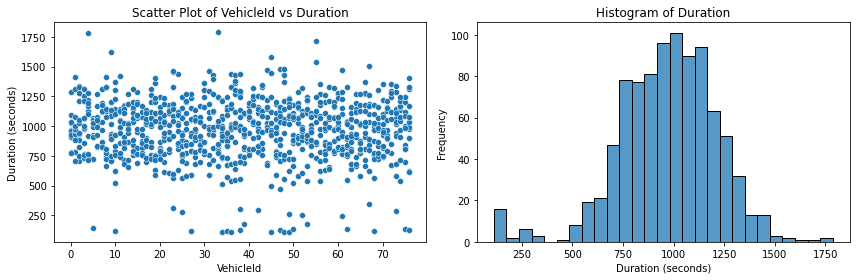

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Subplot 1 - Scatter plot of VehicleId vs Duration
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

sns.scatterplot(data=onewaytime, x="VehicleId", y="duration", ax=ax1)
ax1.set_title('Scatter Plot of VehicleId vs Duration')
ax1.set_xlabel('VehicleId')
ax1.set_ylabel('Duration (seconds)')

# Subplot 2 - Histogram of Duration
sns.histplot(onewaytime['duration'], ax=ax2)
ax2.set_title('Histogram of Duration')
ax2.set_xlabel('Duration (seconds)')
ax2.set_ylabel('Frequency')

# Adjust layout and spacing
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
onewaytime[onewaytime.VehicleId==10]

,time,stopname,VehicleId,time1,stopname1,VehicleId1,duration,shour,direction
0,2023-02-18 06:11:58,GR,10,2023-02-18 06:20:37,LES REMPARTS,10.0,519.0,6,GR-LES REMPARTS
4,2023-02-18 07:47:51,GR,10,2023-02-18 08:01:05,LES REMPARTS,10.0,794.0,7,GR-LES REMPARTS
6,2023-02-18 09:42:41,GR,10,2023-02-18 10:05:35,LES REMPARTS,10.0,1374.0,9,GR-LES REMPARTS
7,2023-02-18 12:04:21,GR,10,2023-02-18 12:23:26,LES REMPARTS,10.0,1145.0,12,GR-LES REMPARTS
9,2023-02-18 14:26:44,GR,10,2023-02-18 14:45:06,LES REMPARTS,10.0,1102.0,14,GR-LES REMPARTS
11,2023-02-18 17:08:14,GR,10,2023-02-18 17:18:37,LES REMPARTS,10.0,623.0,17,GR-LES REMPARTS
0,2023-02-18 06:07:58,LES REMPARTS,10,2023-02-18 06:09:55,GR,10.0,117.0,6,LES REMPARTS-GR
2,2023-02-18 07:28:32,LES REMPARTS,10,2023-02-18 07:41:11,GR,10.0,759.0,7,LES REMPARTS-GR
4,2023-02-18 09:22:38,LES REMPARTS,10,2023-02-18 09:36:29,GR,10.0,831.0,9,LES REMPARTS-GR
6,2023-02-18 11:39:10,LES REMPARTS,10,2023-02-18 12:00:54,GR,10.0,1304.0,11,LES REMPARTS-GR


In [ ]:
#when leaving service or entering service gps is kept on , so we need to get rid of them
dropindex=onewaytime[onewaytime.duration <= 300]

dropindex

,time,stopname,VehicleId,time1,stopname1,VehicleId1,duration,shour,direction
12,2023-02-18 18:38:29,GR,25,2023-02-18 18:43:07,LES REMPARTS,25.0,278.0,18,GR-LES REMPARTS
11,2023-02-14 18:17:22,GR,42,2023-02-14 18:22:14,LES REMPARTS,42.0,292.0,18,GR-LES REMPARTS
13,2023-02-23 19:04:49,GR,49,2023-02-23 19:09:13,LES REMPARTS,49.0,264.0,19,GR-LES REMPARTS
12,2023-02-27 18:43:31,GR,52,2023-02-27 18:47:40,LES REMPARTS,52.0,249.0,18,GR-LES REMPARTS
10,2023-02-09 18:37:29,GR,61,2023-02-09 18:41:35,LES REMPARTS,61.0,246.0,18,GR-LES REMPARTS
11,2023-02-23 18:52:09,GR,73,2023-02-23 18:56:52,LES REMPARTS,73.0,283.0,18,GR-LES REMPARTS
0,2023-02-12 06:44:25,LES REMPARTS,5,2023-02-12 06:46:44,GR,5.0,139.0,6,LES REMPARTS-GR
0,2023-02-18 06:07:58,LES REMPARTS,10,2023-02-18 06:09:55,GR,10.0,117.0,6,LES REMPARTS-GR
0,2023-02-25 06:16:08,LES REMPARTS,27,2023-02-25 06:18:08,GR,27.0,120.0,6,LES REMPARTS-GR
0,2023-02-05 06:03:30,LES REMPARTS,34,2023-02-05 06:05:21,GR,34.0,111.0,6,LES REMPARTS-GR


In [ ]:
droplist=[[d, a, v] for d, a,v in zip (dropindex["time"],dropindex["time1"],dropindex["VehicleId"])]

<AxesSubplot:xlabel='duration'>

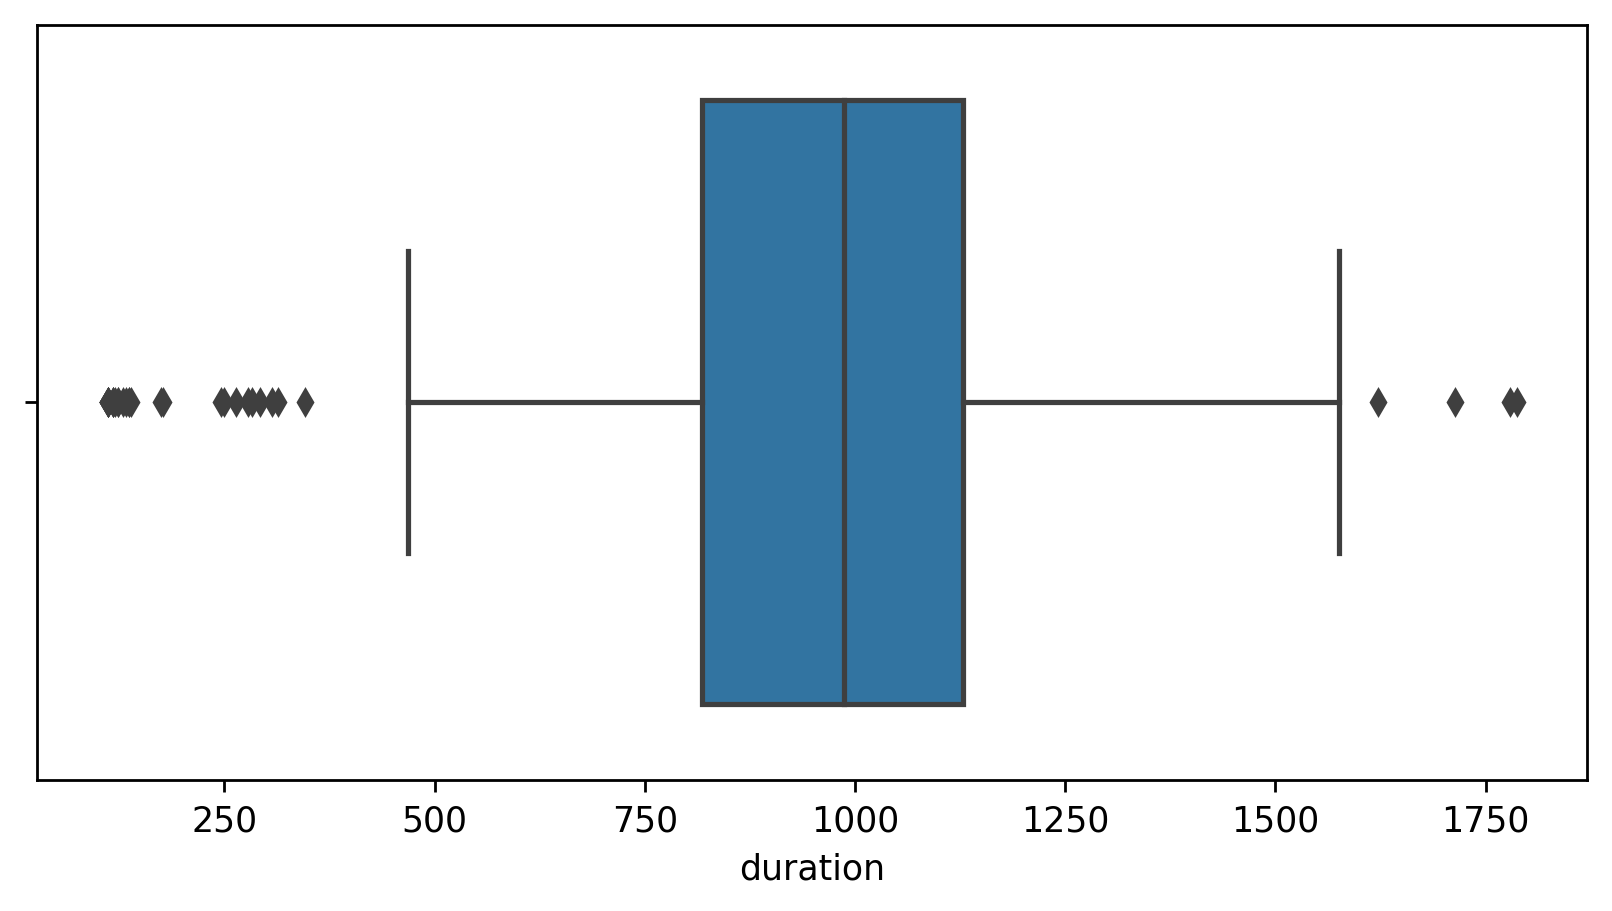

In [ ]:
fig= plt.figure(1,(8,4),dpi = 250)
sns.boxplot(x=onewaytime['duration'])

In [ ]:
q1 = onewaytime['duration'].quantile(0.25)
q3 = onewaytime['duration'].quantile(0.75)
iqr = q3 - q1

onewaytime = onewaytime[(onewaytime['duration'] > q1 - 1.5*iqr) & (onewaytime['duration'] < q3 + 1.5*iqr)]


onewaytime = onewaytime[onewaytime.duration > 1500]
onewaytime = onewaytime[onewaytime.duration < 4000]

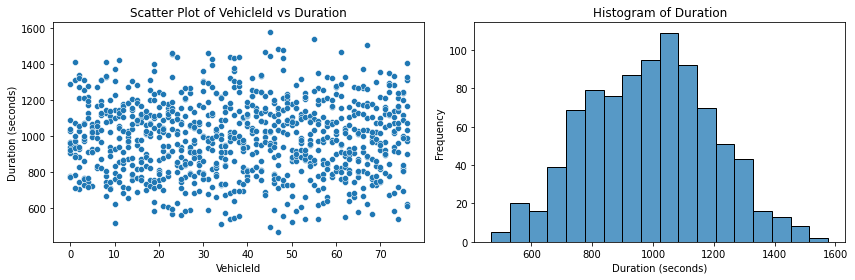

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Subplot 1 - Scatter plot of VehicleId vs Duration
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

sns.scatterplot(data=onewaytime, x="VehicleId", y="duration", ax=ax1)
ax1.set_title('Scatter Plot of VehicleId vs Duration')
ax1.set_xlabel('VehicleId')
ax1.set_ylabel('Duration (seconds)')

# Subplot 2 - Histogram of Duration
sns.histplot(onewaytime['duration'], ax=ax2)
ax2.set_title('Histogram of Duration')
ax2.set_xlabel('Duration (seconds)')
ax2.set_ylabel('Frequency')

# Adjust layout and spacing
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
# Select the row with the longest duration
longest_duration = onewaytime.nlargest(1, 'duration')

# Select the row with the shortest duration
shortest_duration = onewaytime.nsmallest(1, 'duration')


In [ ]:
longest_duration

,time,stopname,VehicleId,time1,stopname1,VehicleId1,duration,shour,direction
6,2023-02-19 09:57:48,GR,45,2023-02-19 10:24:04,LES REMPARTS,45.0,1576.0,9,GR-LES REMPARTS


In [ ]:
shortest_duration

,time,stopname,VehicleId,time1,stopname1,VehicleId1,duration,shour,direction
0,2023-02-21 06:03:06,GR,47,2023-02-21 06:10:54,LES REMPARTS,47.0,468.0,6,GR-LES REMPARTS


In [ ]:
onewaytime.head()

,time,stopname,VehicleId,time1,stopname1,VehicleId1,duration,shour,direction
1,2023-02-05 07:20:26,GR,0,2023-02-05 07:33:25,LES REMPARTS,0.0,779.0,7,GR-LES REMPARTS
2,2023-02-05 09:11:16,GR,0,2023-02-05 09:28:23,LES REMPARTS,0.0,1027.0,9,GR-LES REMPARTS
4,2023-02-05 11:16:23,GR,0,2023-02-05 11:37:50,LES REMPARTS,0.0,1287.0,11,GR-LES REMPARTS
6,2023-02-05 13:26:00,GR,0,2023-02-05 13:43:18,LES REMPARTS,0.0,1038.0,13,GR-LES REMPARTS
11,2023-02-05 15:37:29,GR,0,2023-02-05 15:55:38,LES REMPARTS,0.0,1089.0,15,GR-LES REMPARTS


In [ ]:
onewaytimealler=onewaytime[onewaytime['direction']=="GR-LES TOURS 01"]
# convert time column to datetime format
onewaytimealler['time'] = pd.to_datetime(onewaytimealler['time'])

# sort dataframe by time
onewaytimealler = onewaytimealler.sort_values(by='time')

In [ ]:

# calculate time difference between consecutive rows
onewaytimealler['timediff'] = onewaytimealler['time'].diff()

# calculate average time difference
avg_timediff = onewaytimealler['timediff'].mean()

print('Average time difference:', avg_timediff)


Average time difference: NaT


In [ ]:
onewaytimeretour=onewaytime[onewaytime['direction']=="LES TOURS 01-GR"]
# convert time column to datetime format
onewaytimeretour['time'] = pd.to_datetime(onewaytimeretour['time'])

# sort dataframe by time
onewaytimeretour = onewaytimeretour.sort_values(by='time')


In [ ]:

# calculate time difference between consecutive rows
onewaytimeretour['timediff'] = onewaytimeretour['time'].diff()

# calculate average time difference
avg_timediff = onewaytimeretour['timediff'].mean()

print('Average time difference:', avg_timediff)


Average time difference: NaT


In [ ]:
onewaytimealler

,time,stopname,VehicleId,time1,stopname1,VehicleId1,duration,shour,direction,timediff


In [ ]:
onewaytimeretour

,time,stopname,VehicleId,time1,stopname1,VehicleId1,duration,shour,direction,timediff


In [ ]:

# filter the data for Feb 1
feb1_data = onewaytimeretour[(onewaytimeretour['time'] >= '2023-02-01 00:00:00') & (onewaytimeretour['time'] < '2023-02-02 00:00:00')]
print('11 trips')
feb1_data



11 trips


,time,stopname,VehicleId,time1,stopname1,VehicleId1,duration,shour,direction,timediff


In [ ]:
onewaytime['weekday'] = onewaytime['time'].dt.day_of_week
onewaytime['date'] = onewaytime['time'].dt.date
onewaytime['time'] = onewaytime['time'].dt.time
onewaytime['time1'] = onewaytime['time1'].dt.time


In [ ]:
# Create categorical feature for time of day
onewaytime["time_of_day"] = pd.cut(onewaytime["shour"], bins=[0, 6, 12, 18, 24], labels=["Night", "Morning", "Afternoon", "Evening"])

In [ ]:
onewaytime

,time,stopname,VehicleId,time1,stopname1,VehicleId1,duration,shour,direction,weekday,date,time_of_day
1,07:20:26,GR,0,07:33:25,LES REMPARTS,0.0,779.0,7,GR-LES REMPARTS,6,2023-02-05,Morning
2,09:11:16,GR,0,09:28:23,LES REMPARTS,0.0,1027.0,9,GR-LES REMPARTS,6,2023-02-05,Morning
4,11:16:23,GR,0,11:37:50,LES REMPARTS,0.0,1287.0,11,GR-LES REMPARTS,6,2023-02-05,Morning
6,13:26:00,GR,0,13:43:18,LES REMPARTS,0.0,1038.0,13,GR-LES REMPARTS,6,2023-02-05,Afternoon
11,15:37:29,GR,0,15:55:38,LES REMPARTS,0.0,1089.0,15,GR-LES REMPARTS,6,2023-02-05,Afternoon
...,...,...,...,...,...,...,...,...,...,...,...,...
2,07:18:04,LES REMPARTS,76,07:28:15,GR,76.0,611.0,7,LES REMPARTS-GR,1,2023-02-28,Morning
4,09:28:25,LES REMPARTS,76,09:43:28,GR,76.0,903.0,9,LES REMPARTS-GR,1,2023-02-28,Morning
6,11:32:21,LES REMPARTS,76,11:54:27,GR,76.0,1326.0,11,LES REMPARTS-GR,1,2023-02-28,Morning
8,14:04:35,LES REMPARTS,76,14:21:46,GR,76.0,1031.0,14,LES REMPARTS-GR,1,2023-02-28,Afternoon


<AxesSubplot:xlabel='time_of_day', ylabel='duration'>

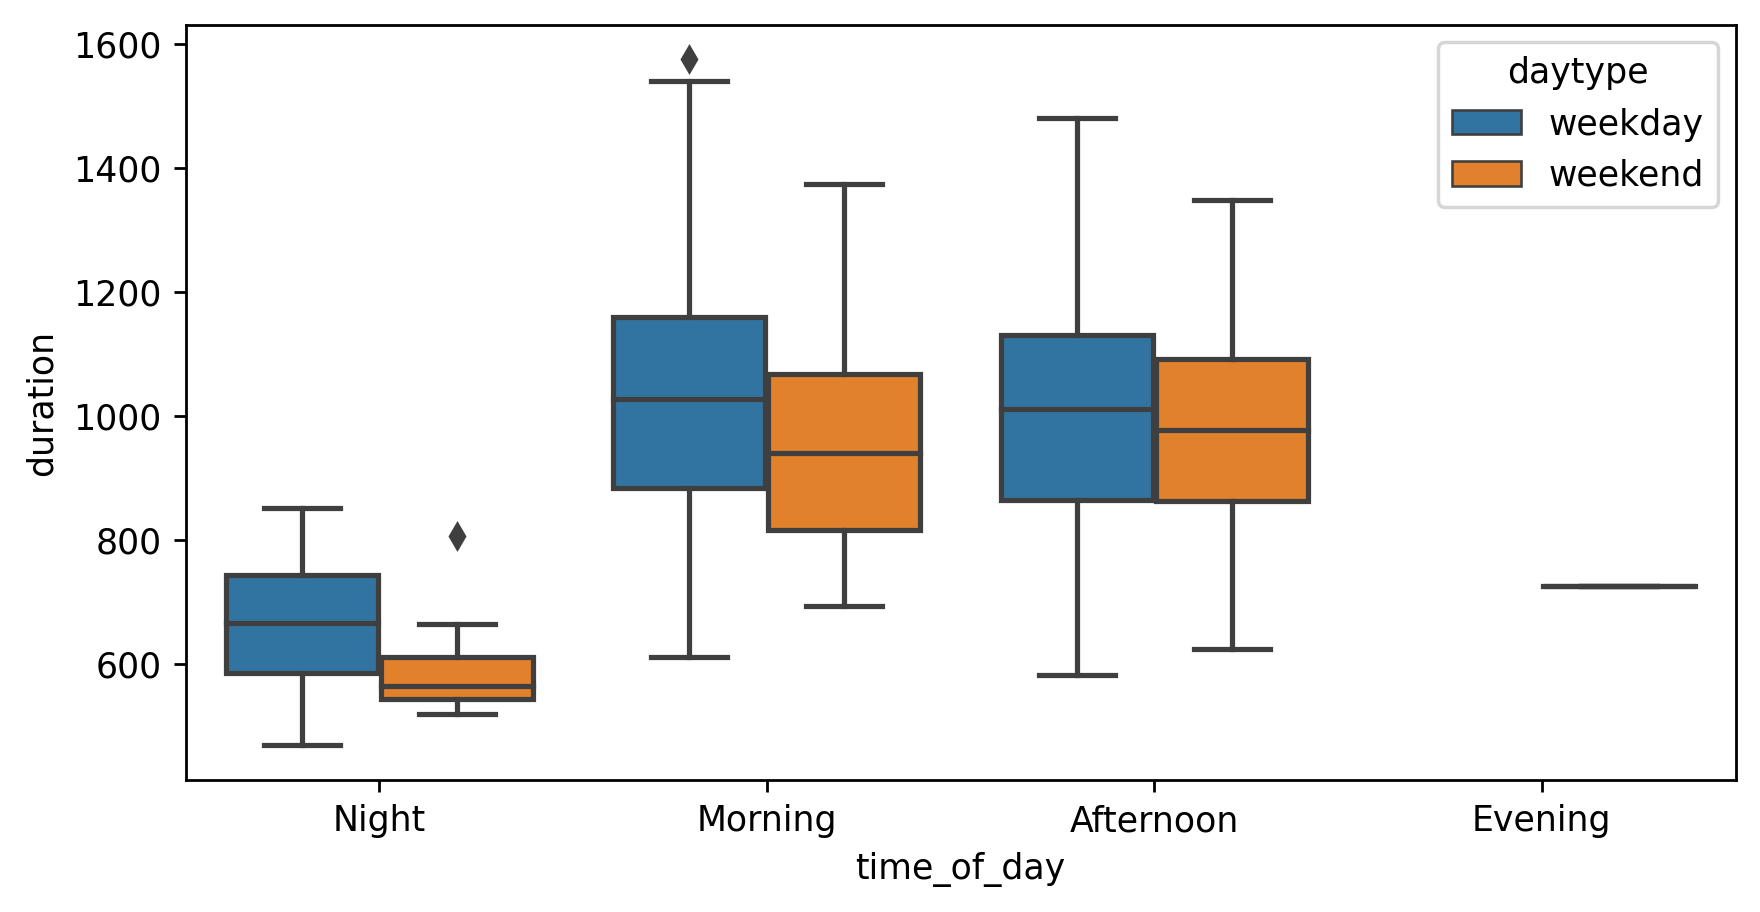

In [ ]:
# Extract relevant columns and create new column for time of day
onewaytime["daytype"] = onewaytime["weekday"].apply(lambda x: 'weekend' if x in [4, 5] else 'weekday')
# Create boxplot
fig = plt.figure(1, (8, 4), dpi=250)
sns.boxplot(x="time_of_day", y="duration", hue="daytype", data=onewaytime)


In [ ]:
onewaytime

,time,stopname,VehicleId,time1,stopname1,VehicleId1,duration,shour,direction,weekday,date,time_of_day,daytype
1,07:20:26,GR,0,07:33:25,LES REMPARTS,0.0,779.0,7,GR-LES REMPARTS,6,2023-02-05,Morning,weekday
2,09:11:16,GR,0,09:28:23,LES REMPARTS,0.0,1027.0,9,GR-LES REMPARTS,6,2023-02-05,Morning,weekday
4,11:16:23,GR,0,11:37:50,LES REMPARTS,0.0,1287.0,11,GR-LES REMPARTS,6,2023-02-05,Morning,weekday
6,13:26:00,GR,0,13:43:18,LES REMPARTS,0.0,1038.0,13,GR-LES REMPARTS,6,2023-02-05,Afternoon,weekday
11,15:37:29,GR,0,15:55:38,LES REMPARTS,0.0,1089.0,15,GR-LES REMPARTS,6,2023-02-05,Afternoon,weekday
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,07:18:04,LES REMPARTS,76,07:28:15,GR,76.0,611.0,7,LES REMPARTS-GR,1,2023-02-28,Morning,weekday
4,09:28:25,LES REMPARTS,76,09:43:28,GR,76.0,903.0,9,LES REMPARTS-GR,1,2023-02-28,Morning,weekday
6,11:32:21,LES REMPARTS,76,11:54:27,GR,76.0,1326.0,11,LES REMPARTS-GR,1,2023-02-28,Morning,weekday
8,14:04:35,LES REMPARTS,76,14:21:46,GR,76.0,1031.0,14,LES REMPARTS-GR,1,2023-02-28,Afternoon,weekday


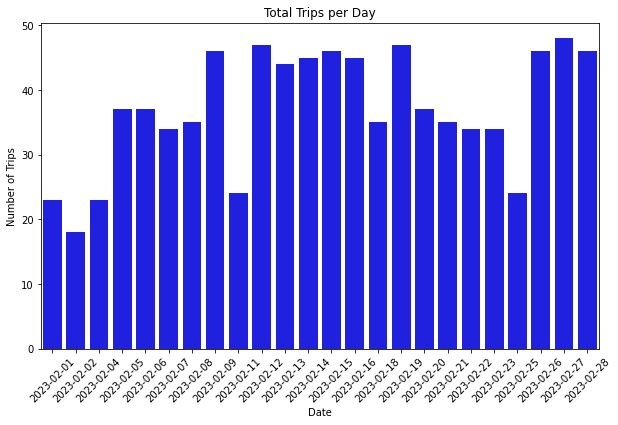

In [ ]:

dftrips=onewaytime
# Group the dataframe by date and count the number of trips for each date
trips_per_day = dftrips.groupby('date')['time'].count()

# Create a bar plot of the counts
plt.figure(figsize=(10, 6))
sns.barplot(x=trips_per_day.index, y=trips_per_day.values, color='blue')
plt.title('Total Trips per Day')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45)
plt.show()


In [ ]:
onewaytime.weekday.unique()

array([6, 0, 1, 2, 3, 5])

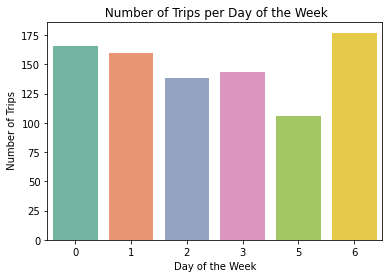

In [ ]:

# Group the data by day of the week and calculate the mean number of trips
trips_per_day = dftrips.groupby('weekday')['VehicleId'].count().reset_index(name='trips_mean')

# Plot a bar chart
sns.barplot(x='weekday', y='trips_mean', data=trips_per_day, palette='Set2')
plt.title(' Number of Trips per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel(' Number of Trips')
plt.show()


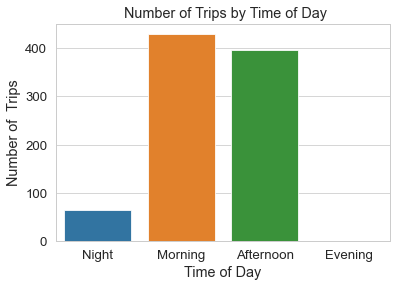

In [ ]:
# Group the data by time of day and calculate the average number of trips
avg_trips = dftrips.groupby('time_of_day')['VehicleId'].count().reset_index()
avg_trips = avg_trips.rename(columns={'VehicleId': 'Average Trips'})

# Set the style and context of the plot
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.5)

# Create the bar plot
sns.barplot(x='time_of_day', y='Average Trips', data=avg_trips)

# Set the axis labels and title
plt.xlabel('Time of Day')
plt.ylabel('Number of  Trips')
plt.title(' Number of Trips by Time of Day')

# Show the plot
plt.show()


In [ ]:
dftrips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 890 entries, 1 to 10
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   time         890 non-null    object  
 1   stopname     890 non-null    object  
 2   VehicleId    890 non-null    int64   
 3   time1        890 non-null    object  
 4   stopname1    890 non-null    object  
 5   VehicleId1   890 non-null    float64 
 6   duration     890 non-null    float64 
 7   shour        890 non-null    int64   
 8   direction    890 non-null    object  
 9   weekday      890 non-null    int64   
 10  date         890 non-null    object  
 11  time_of_day  890 non-null    category
 12  daytype      890 non-null    object  
dtypes: category(1), float64(2), int64(3), object(7)
memory usage: 91.5+ KB


Text(0, 0.5, 'Number of buses')

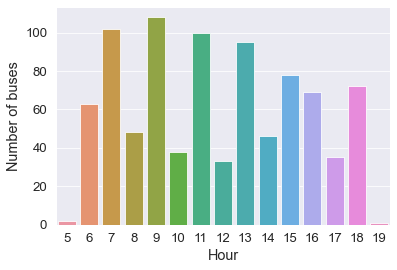

In [ ]:
# set seaborn style
sns.set_style('darkgrid')

# group data by hour and count the number of occurrences
df_hourly = dftrips.groupby('shour')['shour'].count()

# create barplot
sns.barplot(x=df_hourly.index, y=df_hourly.values)
plt.xlabel('Hour')
plt.ylabel('Number of buses')


In [ ]:
# Convert the time component to a float
onewaytime['time'] = onewaytime['time'].apply(lambda x: float(x.strftime('%H.%M%S')))
onewaytime['time1'] = onewaytime['time1'].apply(lambda x: float(x.strftime('%H.%M%S')))


In [ ]:
onewaytime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 890 entries, 1 to 10
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   time         890 non-null    float64 
 1   stopname     890 non-null    object  
 2   VehicleId    890 non-null    int64   
 3   time1        890 non-null    float64 
 4   stopname1    890 non-null    object  
 5   VehicleId1   890 non-null    float64 
 6   duration     890 non-null    float64 
 7   shour        890 non-null    int64   
 8   direction    890 non-null    object  
 9   weekday      890 non-null    int64   
 10  date         890 non-null    object  
 11  time_of_day  890 non-null    category
 12  daytype      890 non-null    object  
dtypes: category(1), float64(4), int64(3), object(5)
memory usage: 91.5+ KB


In [ ]:
onewaytime['shour1'] = onewaytime['shour']+1
onewaytime["date"]=pd.to_datetime(onewaytime["date"])
onewaytime.tail()


,time,stopname,VehicleId,time1,stopname1,VehicleId1,duration,shour,direction,weekday,date,time_of_day,daytype,shour1
2,7.1804,LES REMPARTS,76,7.2815,GR,76.0,611.0,7,LES REMPARTS-GR,1,2023-02-28,Morning,weekday,8
4,9.2825,LES REMPARTS,76,9.4328,GR,76.0,903.0,9,LES REMPARTS-GR,1,2023-02-28,Morning,weekday,10
6,11.3221,LES REMPARTS,76,11.5427,GR,76.0,1326.0,11,LES REMPARTS-GR,1,2023-02-28,Morning,weekday,12
8,14.0435,LES REMPARTS,76,14.2146,GR,76.0,1031.0,14,LES REMPARTS-GR,1,2023-02-28,Afternoon,weekday,15
10,16.1536,LES REMPARTS,76,16.3329,GR,76.0,1073.0,16,LES REMPARTS-GR,1,2023-02-28,Afternoon,weekday,17


In [ ]:
weather=pd.read_csv("../data/interim/weathercleaned.csv",index_col=0)
weather

,date,temp,feelslike,dew,humidity,precip,precipprob,snow,snowdepth,windgust,winddir,windspeed,cloudcover,conditions,icon
0,2023-02-01T00:00:00,-1.8,-3.9,-2.9,92.52,0.000,0,0,0,7.2,8.0,5.5,50.0,Partially cloudy,partly-cloudy-night
1,2023-02-01T01:00:00,-1.8,-3.9,-2.1,97.51,0.000,0,0,0,6.1,347.0,5.6,60.3,Partially cloudy,partly-cloudy-night
2,2023-02-01T02:00:00,0.1,-2.4,-1.9,86.16,0.000,0,0,0,4.7,9.0,7.6,43.7,Partially cloudy,partly-cloudy-night
3,2023-02-01T03:00:00,-2.8,-5.9,-2.9,99.46,0.000,0,0,0,6.1,9.0,7.6,43.7,Partially cloudy,partly-cloudy-night
4,2023-02-01T04:00:00,-0.7,-3.4,-1.1,97.06,0.000,0,0,0,6.1,348.0,7.5,1.5,Clear,clear-night
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,2023-02-28T19:00:00,2.3,-1.9,-5.0,58.76,0.003,100,0,0,35.6,250.0,16.9,75.2,"Rain, Partially cloudy",rain
668,2023-02-28T20:00:00,3.1,-2.2,-4.9,55.88,0.000,0,0,0,38.2,260.0,27.7,88.9,Partially cloudy,partly-cloudy-night
669,2023-02-28T21:00:00,2.1,-3.5,-3.9,64.71,0.000,0,0,0,38.5,270.0,27.6,88.9,Partially cloudy,partly-cloudy-night
670,2023-02-28T22:00:00,2.1,-3.6,-2.7,70.13,0.000,0,0,0,38.2,260.0,29.5,75.3,Partially cloudy,partly-cloudy-night


In [ ]:
weather["date"]=pd.to_datetime(weather["date"])
weather['shour'] = weather['date'].dt.hour
weather

,date,temp,feelslike,dew,humidity,precip,precipprob,snow,snowdepth,windgust,winddir,windspeed,cloudcover,conditions,icon,shour
0,2023-02-01 00:00:00,-1.8,-3.9,-2.9,92.52,0.000,0,0,0,7.2,8.0,5.5,50.0,Partially cloudy,partly-cloudy-night,0
1,2023-02-01 01:00:00,-1.8,-3.9,-2.1,97.51,0.000,0,0,0,6.1,347.0,5.6,60.3,Partially cloudy,partly-cloudy-night,1
2,2023-02-01 02:00:00,0.1,-2.4,-1.9,86.16,0.000,0,0,0,4.7,9.0,7.6,43.7,Partially cloudy,partly-cloudy-night,2
3,2023-02-01 03:00:00,-2.8,-5.9,-2.9,99.46,0.000,0,0,0,6.1,9.0,7.6,43.7,Partially cloudy,partly-cloudy-night,3
4,2023-02-01 04:00:00,-0.7,-3.4,-1.1,97.06,0.000,0,0,0,6.1,348.0,7.5,1.5,Clear,clear-night,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,2023-02-28 19:00:00,2.3,-1.9,-5.0,58.76,0.003,100,0,0,35.6,250.0,16.9,75.2,"Rain, Partially cloudy",rain,19
668,2023-02-28 20:00:00,3.1,-2.2,-4.9,55.88,0.000,0,0,0,38.2,260.0,27.7,88.9,Partially cloudy,partly-cloudy-night,20
669,2023-02-28 21:00:00,2.1,-3.5,-3.9,64.71,0.000,0,0,0,38.5,270.0,27.6,88.9,Partially cloudy,partly-cloudy-night,21
670,2023-02-28 22:00:00,2.1,-3.6,-2.7,70.13,0.000,0,0,0,38.2,260.0,29.5,75.3,Partially cloudy,partly-cloudy-night,22


In [ ]:
weather["date"]=pd.to_datetime(weather["date"]).dt.date
weather["date"]=pd.to_datetime(weather["date"])
weather.tail()

,date,temp,feelslike,dew,humidity,precip,precipprob,snow,snowdepth,windgust,winddir,windspeed,cloudcover,conditions,icon,shour
667,2023-02-28,2.3,-1.9,-5.0,58.76,0.003,100,0,0,35.6,250.0,16.9,75.2,"Rain, Partially cloudy",rain,19
668,2023-02-28,3.1,-2.2,-4.9,55.88,0.000,0,0,0,38.2,260.0,27.7,88.9,Partially cloudy,partly-cloudy-night,20
669,2023-02-28,2.1,-3.5,-3.9,64.71,0.000,0,0,0,38.5,270.0,27.6,88.9,Partially cloudy,partly-cloudy-night,21
670,2023-02-28,2.1,-3.6,-2.7,70.13,0.000,0,0,0,38.2,260.0,29.5,75.3,Partially cloudy,partly-cloudy-night,22
671,2023-02-28,2.1,-3.5,0.1,86.50,0.000,0,0,0,36.4,270.0,27.7,89.0,Partially cloudy,partly-cloudy-night,23


In [ ]:
# merging  data with weather data (merge on date and hour)
onewaytime = pd.merge(onewaytime,weather, on=['date','shour'])
onewaytime

,time,stopname,VehicleId,time1,stopname1,VehicleId1,duration,shour,direction,weekday,...,precip,precipprob,snow,snowdepth,windgust,winddir,windspeed,cloudcover,conditions,icon
0,7.2026,GR,0,7.3325,LES REMPARTS,0.0,779.0,7,GR-LES REMPARTS,6,...,0.0,0,0,0,7.6,232.0,5.6,54.7,Partially cloudy,partly-cloudy-night
1,7.4419,GR,34,8.0004,LES REMPARTS,34.0,945.0,7,GR-LES REMPARTS,6,...,0.0,0,0,0,7.6,232.0,5.6,54.7,Partially cloudy,partly-cloudy-night
2,7.3202,GR,57,7.5030,LES REMPARTS,57.0,1108.0,7,GR-LES REMPARTS,6,...,0.0,0,0,0,7.6,232.0,5.6,54.7,Partially cloudy,partly-cloudy-night
3,7.1557,LES REMPARTS,34,7.3041,GR,34.0,884.0,7,LES REMPARTS-GR,6,...,0.0,0,0,0,7.6,232.0,5.6,54.7,Partially cloudy,partly-cloudy-night
4,7.0254,LES REMPARTS,57,7.1446,GR,57.0,712.0,7,LES REMPARTS-GR,6,...,0.0,0,0,0,7.6,232.0,5.6,54.7,Partially cloudy,partly-cloudy-night
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
885,18.2539,LES REMPARTS,55,18.3747,GR,55.0,728.0,18,LES REMPARTS-GR,3,...,0.0,0,0,0,31.3,19.0,11.1,50.0,Partially cloudy,partly-cloudy-day
886,14.3035,LES REMPARTS,56,14.5304,GR,56.0,1349.0,14,LES REMPARTS-GR,5,...,0.0,0,0,0,19.4,10.0,11.2,27.4,Partially cloudy,partly-cloudy-day
887,7.4609,LES REMPARTS,62,7.5833,GR,62.0,744.0,7,LES REMPARTS-GR,5,...,0.0,0,0,0,10.8,58.0,11.1,45.4,Partially cloudy,partly-cloudy-night
888,13.5451,LES REMPARTS,62,14.0855,GR,62.0,844.0,13,LES REMPARTS-GR,5,...,0.0,0,0,0,27.0,117.0,11.1,54.5,Partially cloudy,partly-cloudy-day


In [ ]:
from sklearn.preprocessing import LabelEncoder
# Create a label encoder object
le = LabelEncoder()

# Convert the 'direction' column to numerical values
onewaytime['direction'] = le.fit_transform(onewaytime['direction'])
onewaytime['stopname'] = le.fit_transform(onewaytime['stopname'])
onewaytime['stopname1'] = le.fit_transform(onewaytime['stopname1'])
onewaytime['conditions'] = le.fit_transform(onewaytime['conditions'])
onewaytime['icon'] = le.fit_transform(onewaytime['icon'])
onewaytime['time_of_day'] = le.fit_transform(onewaytime['time_of_day'])
onewaytime['daytype'] = le.fit_transform(onewaytime['daytype'])
# Convert the date column to a numerical format
onewaytime['date'] = pd.to_datetime(onewaytime['date']).astype(int)

In [ ]:
onewaytime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 890 entries, 0 to 889
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   time         890 non-null    float64
 1   stopname     890 non-null    int64  
 2   VehicleId    890 non-null    int64  
 3   time1        890 non-null    float64
 4   stopname1    890 non-null    int64  
 5   VehicleId1   890 non-null    float64
 6   duration     890 non-null    float64
 7   shour        890 non-null    int64  
 8   direction    890 non-null    int64  
 9   weekday      890 non-null    int64  
 10  date         890 non-null    int64  
 11  time_of_day  890 non-null    int64  
 12  daytype      890 non-null    int64  
 13  shour1       890 non-null    int64  
 14  temp         890 non-null    float64
 15  feelslike    890 non-null    float64
 16  dew          890 non-null    float64
 17  humidity     890 non-null    float64
 18  precip       890 non-null    float64
 19  precippr

In [ ]:
from sklearn.preprocessing import StandardScaler

# create the scaler object
scaler = StandardScaler()

# define the columns to be scaled
columns_to_scale = ['time','date', 'windgust', 'winddir', 'windspeed', 'cloudcover']

# fit and transform the data
onewaytime[columns_to_scale] = scaler.fit_transform(onewaytime[columns_to_scale])


In [ ]:
onewaytime.tail(20)

,time,stopname,VehicleId,time1,stopname1,VehicleId1,duration,shour,direction,weekday,...,precip,precipprob,snow,snowdepth,windgust,winddir,windspeed,cloudcover,conditions,icon
870,0.420879,1,27,14.1007,0,27.0,914.0,13,1,5,...,0.984,100,0,0,1.458989,0.844172,0.596416,0.550762,4,5
871,1.672543,1,27,18.3554,0,27.0,790.0,18,1,5,...,0.000,0,0,0,0.706019,0.942339,-0.112732,1.427391,2,3
872,1.720211,1,50,18.5132,0,50.0,666.0,18,1,5,...,0.000,0,0,0,0.706019,0.942339,-0.112732,1.427391,2,3
873,-1.460082,1,32,7.0332,0,32.0,715.0,6,1,3,...,0.000,0,0,0,-0.688093,1.521530,-0.349114,0.068791,2,4
874,-0.109977,1,39,12.1217,0,39.0,969.0,11,1,5,...,0.000,0,0,0,0.892398,-1.001383,1.318696,0.065299,2,3
875,-0.139483,1,62,12.0203,0,62.0,1018.0,11,1,5,...,0.000,0,0,0,0.892398,-1.001383,1.318696,0.065299,2,3
876,1.731553,1,39,18.5836,0,39.0,826.0,18,1,5,...,0.000,0,0,0,0.117063,-1.502039,-0.138996,0.065299,2,3
877,1.704910,1,62,18.4740,0,62.0,766.0,18,1,5,...,0.000,0,0,0,0.117063,-1.502039,-0.138996,0.065299,2,3
878,-1.474099,1,54,7.0024,0,54.0,851.0,6,1,2,...,0.000,0,0,0,-1.060851,0.196264,-1.097659,-0.151239,2,4
879,-0.962316,1,54,8.5231,0,54.0,886.0,8,1,2,...,0.000,0,0,0,-1.120492,-1.816176,-0.638026,0.075776,2,3


In [ ]:
features=['time','stopname','VehicleId','VehicleId1','shour','shour1','stopname1','direction','time_of_day','weekday','daytype','date']
X = onewaytime[features]
y = onewaytime['duration']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce t

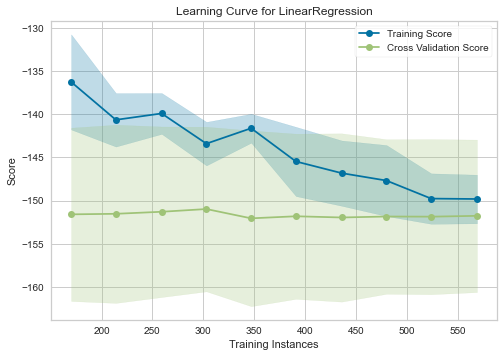

LinearRegression
Best hyperparameters:  {'copy_X': True, 'fit_intercept': True, 'normalize': False}
Best score:  151.81542311880605
Test MAE: 153.405
Test MAPE: 17.791%
Test RMSE: 198.039
Test R^2: 0.052


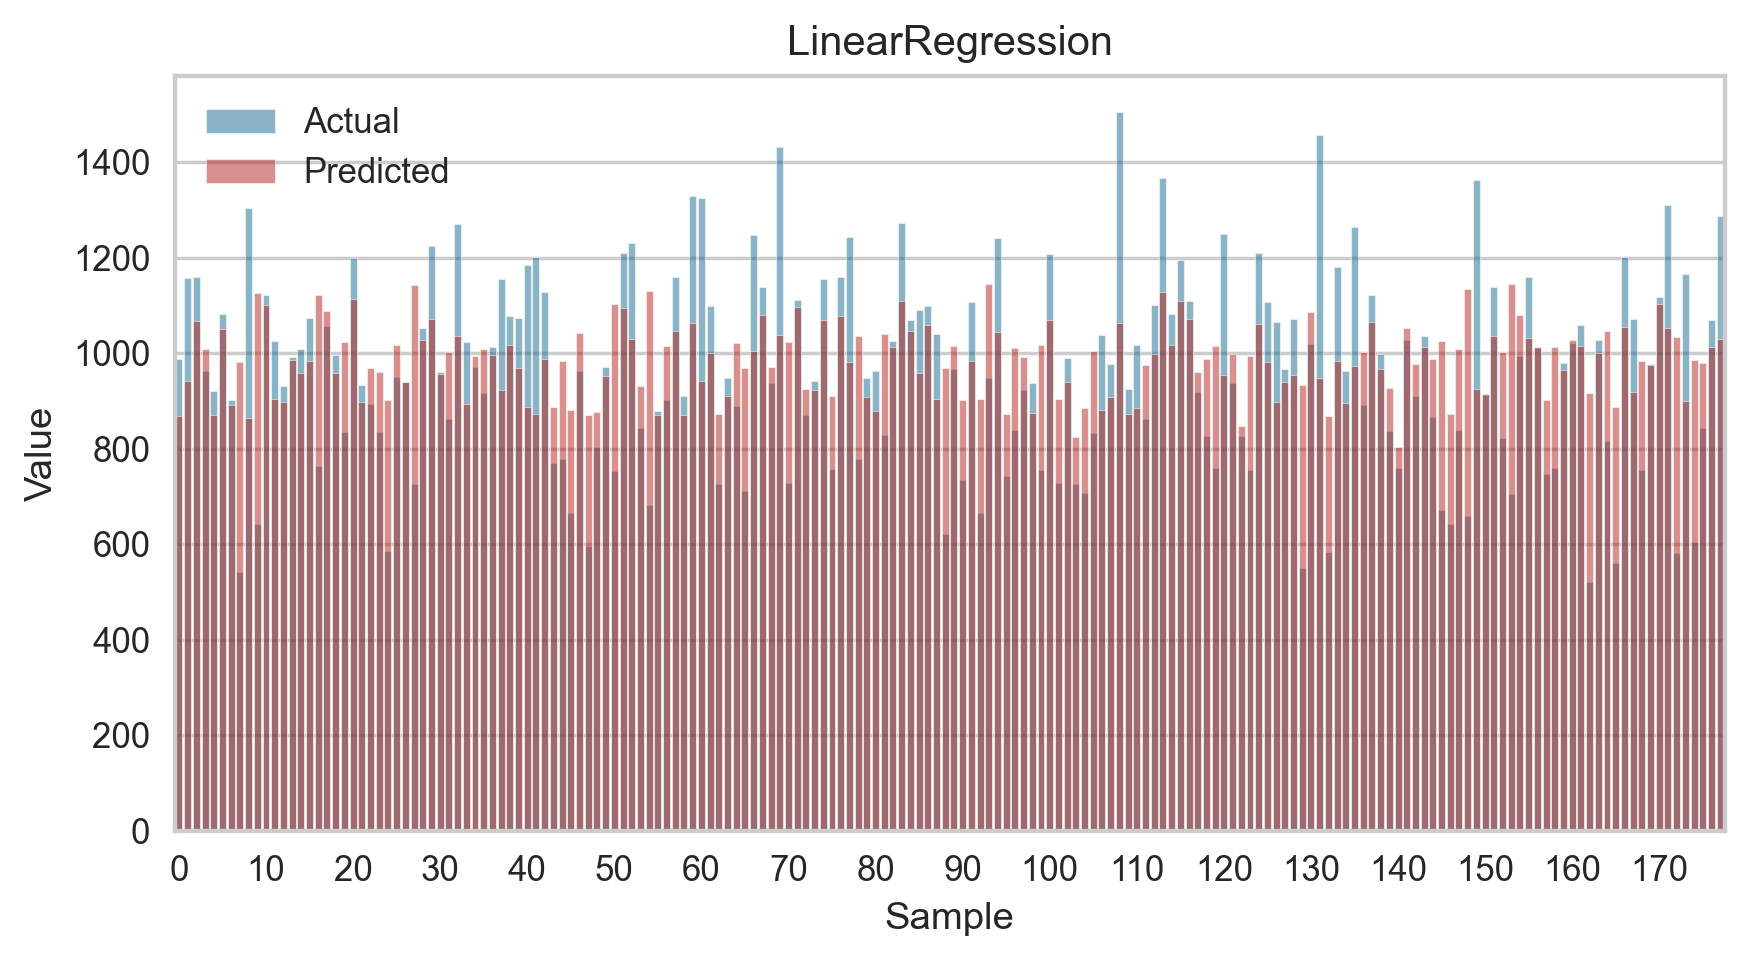

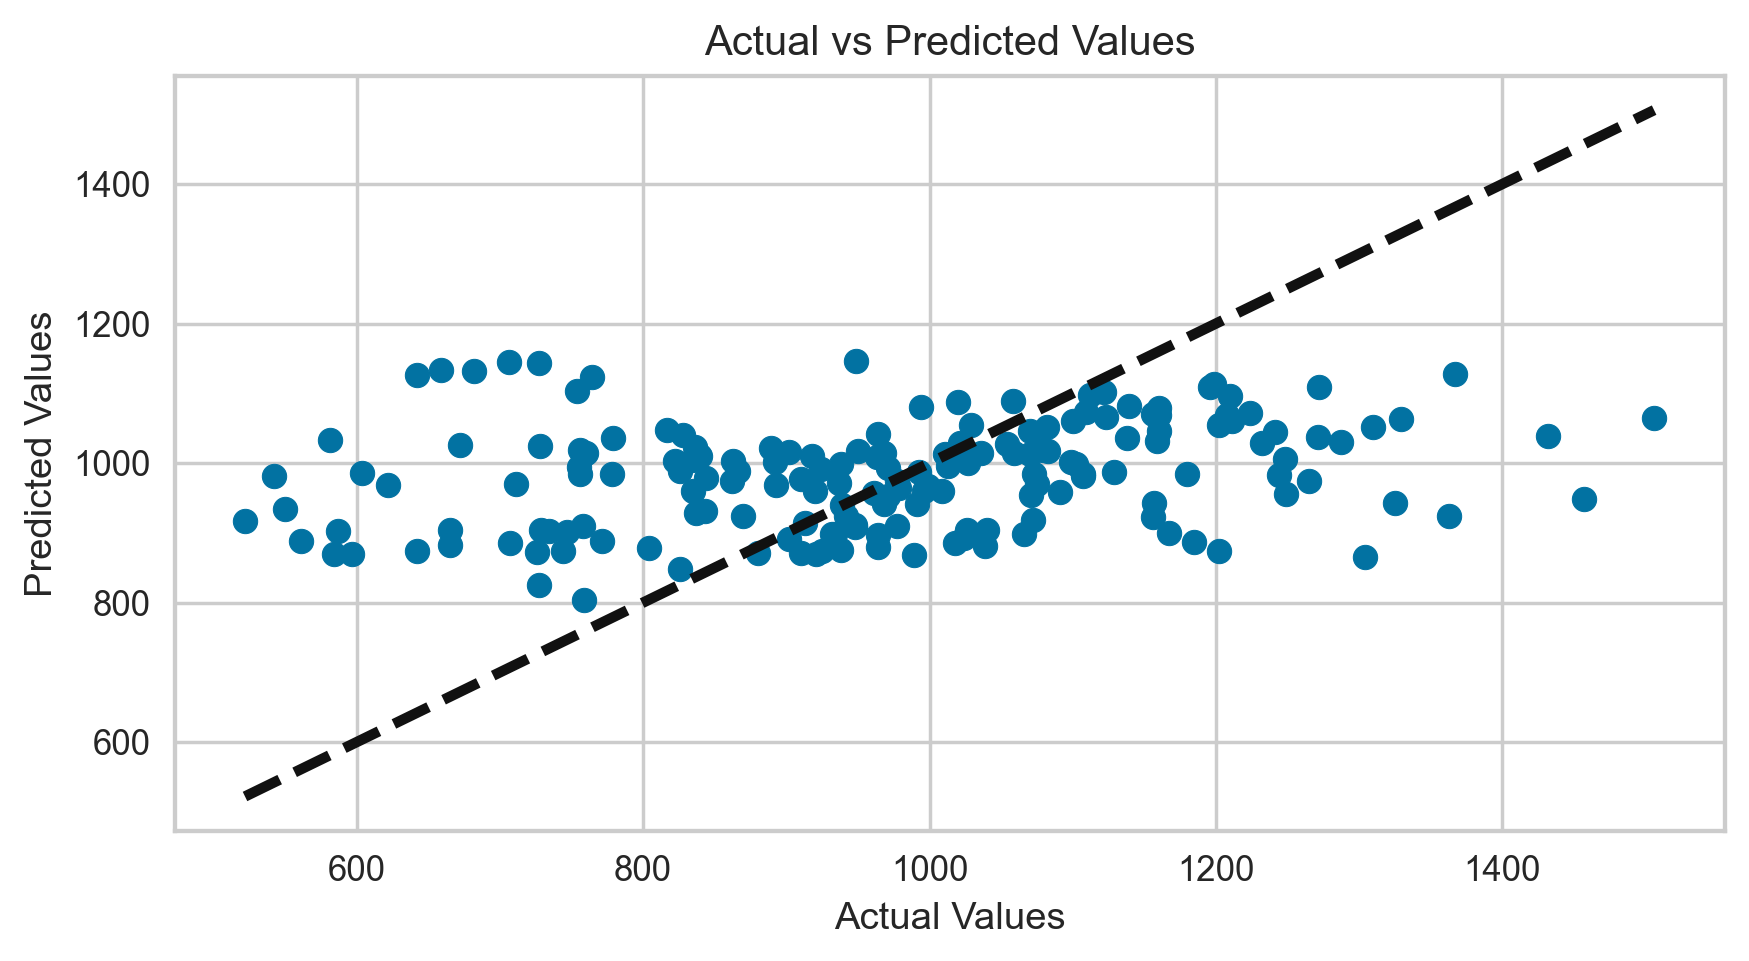

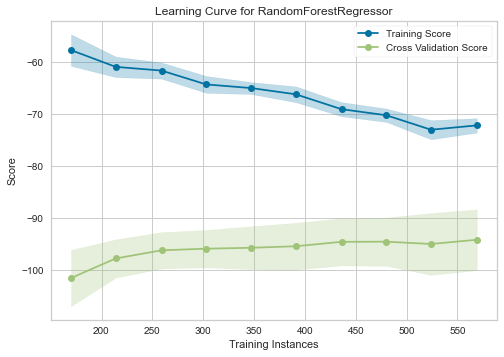

RandomForestRegressor
Best hyperparameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 500}
Best score:  93.1113712805975
Test MAE: 80.134
Test MAPE: 8.260%
Test RMSE: 104.256
Test R^2: 0.737


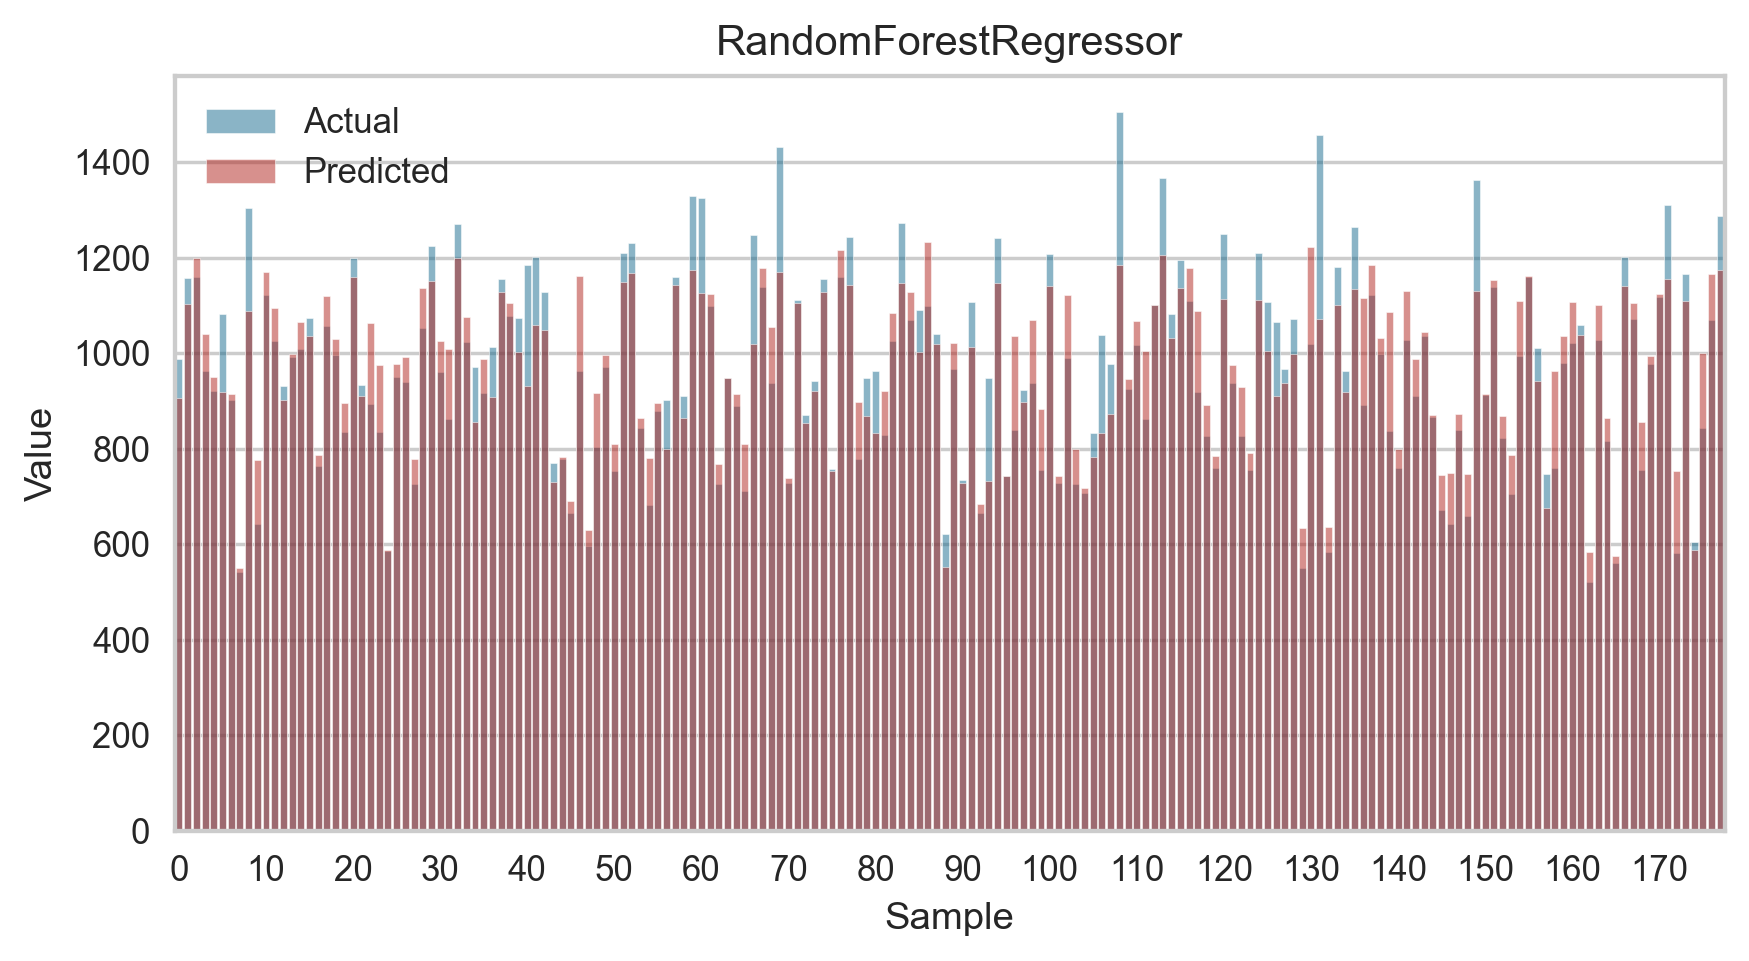

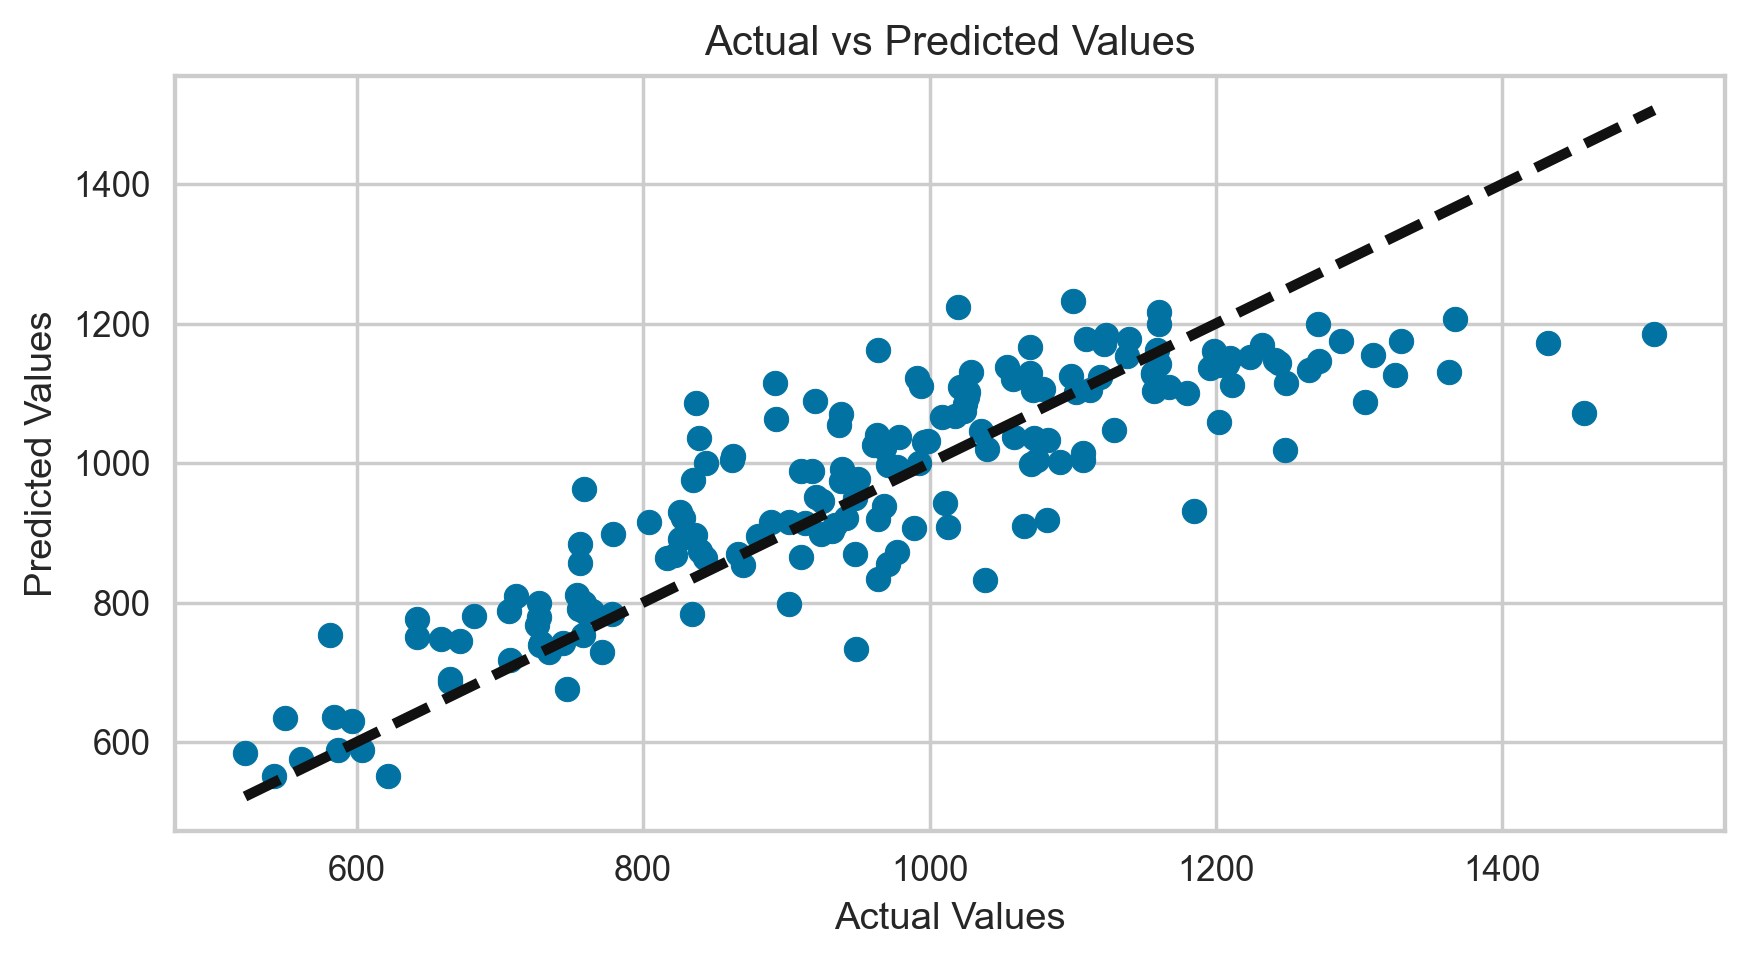

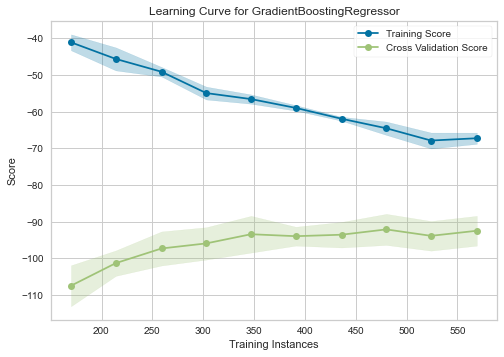

GradientBoostingRegressor
Best hyperparameters:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000}
Best score:  90.5312012084651
Test MAE: 78.202
Test MAPE: 8.034%
Test RMSE: 101.004
Test R^2: 0.753


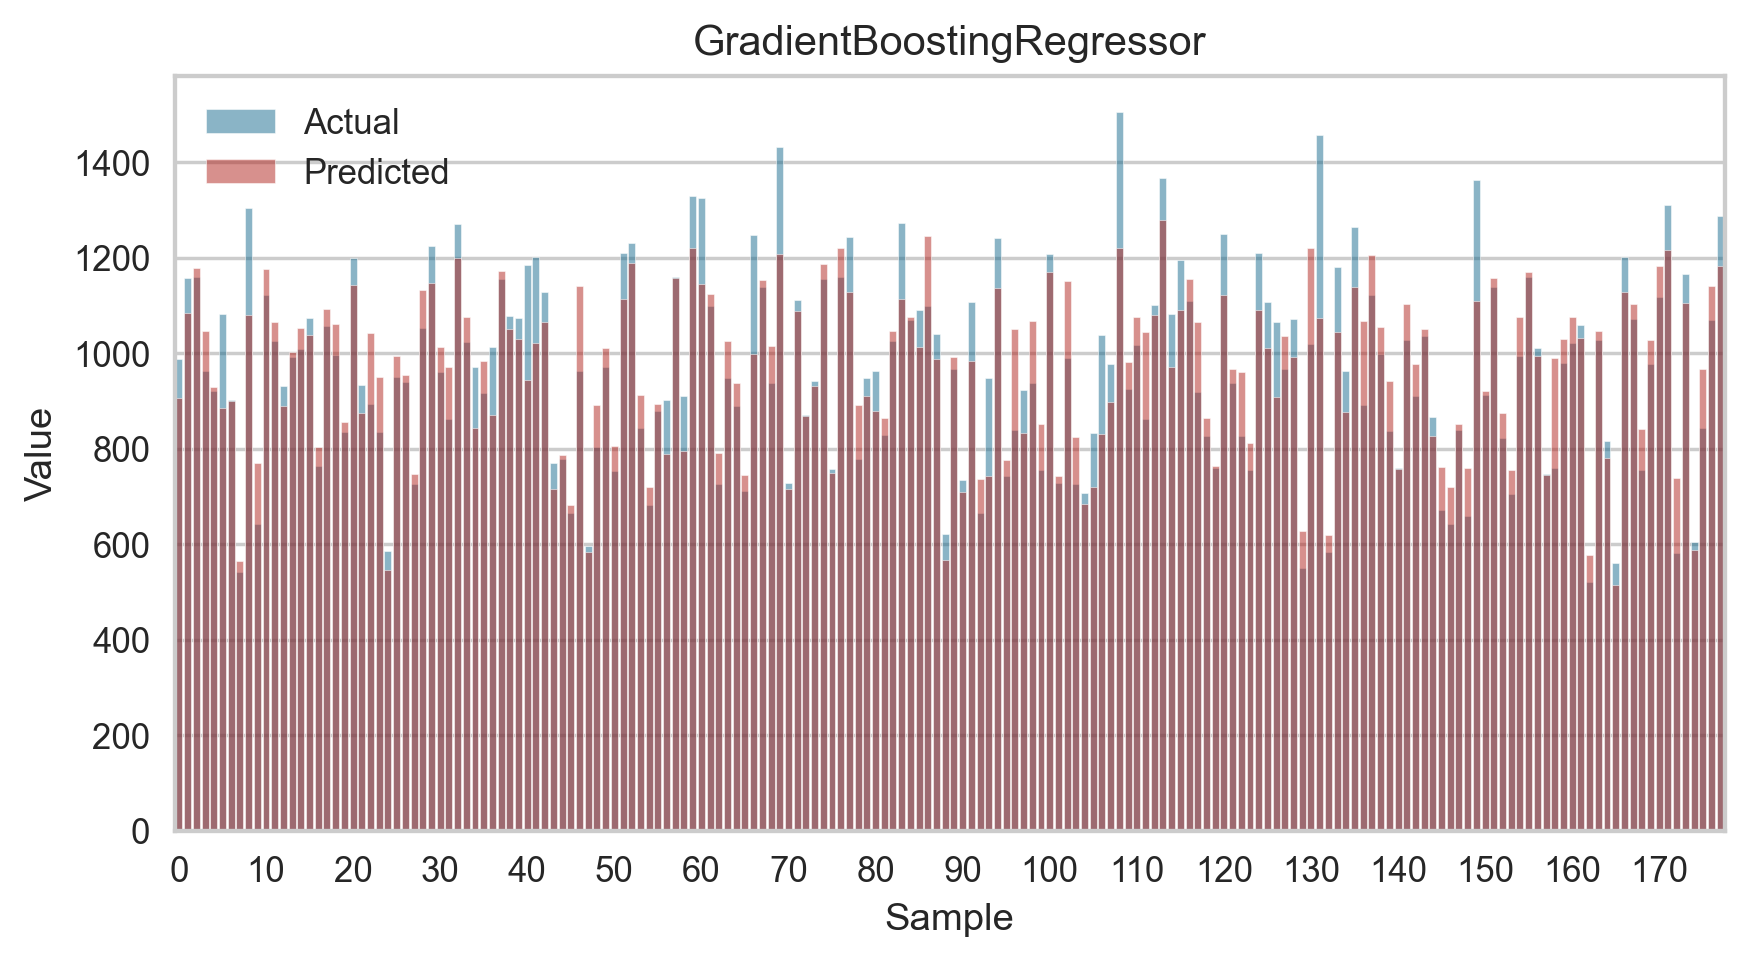

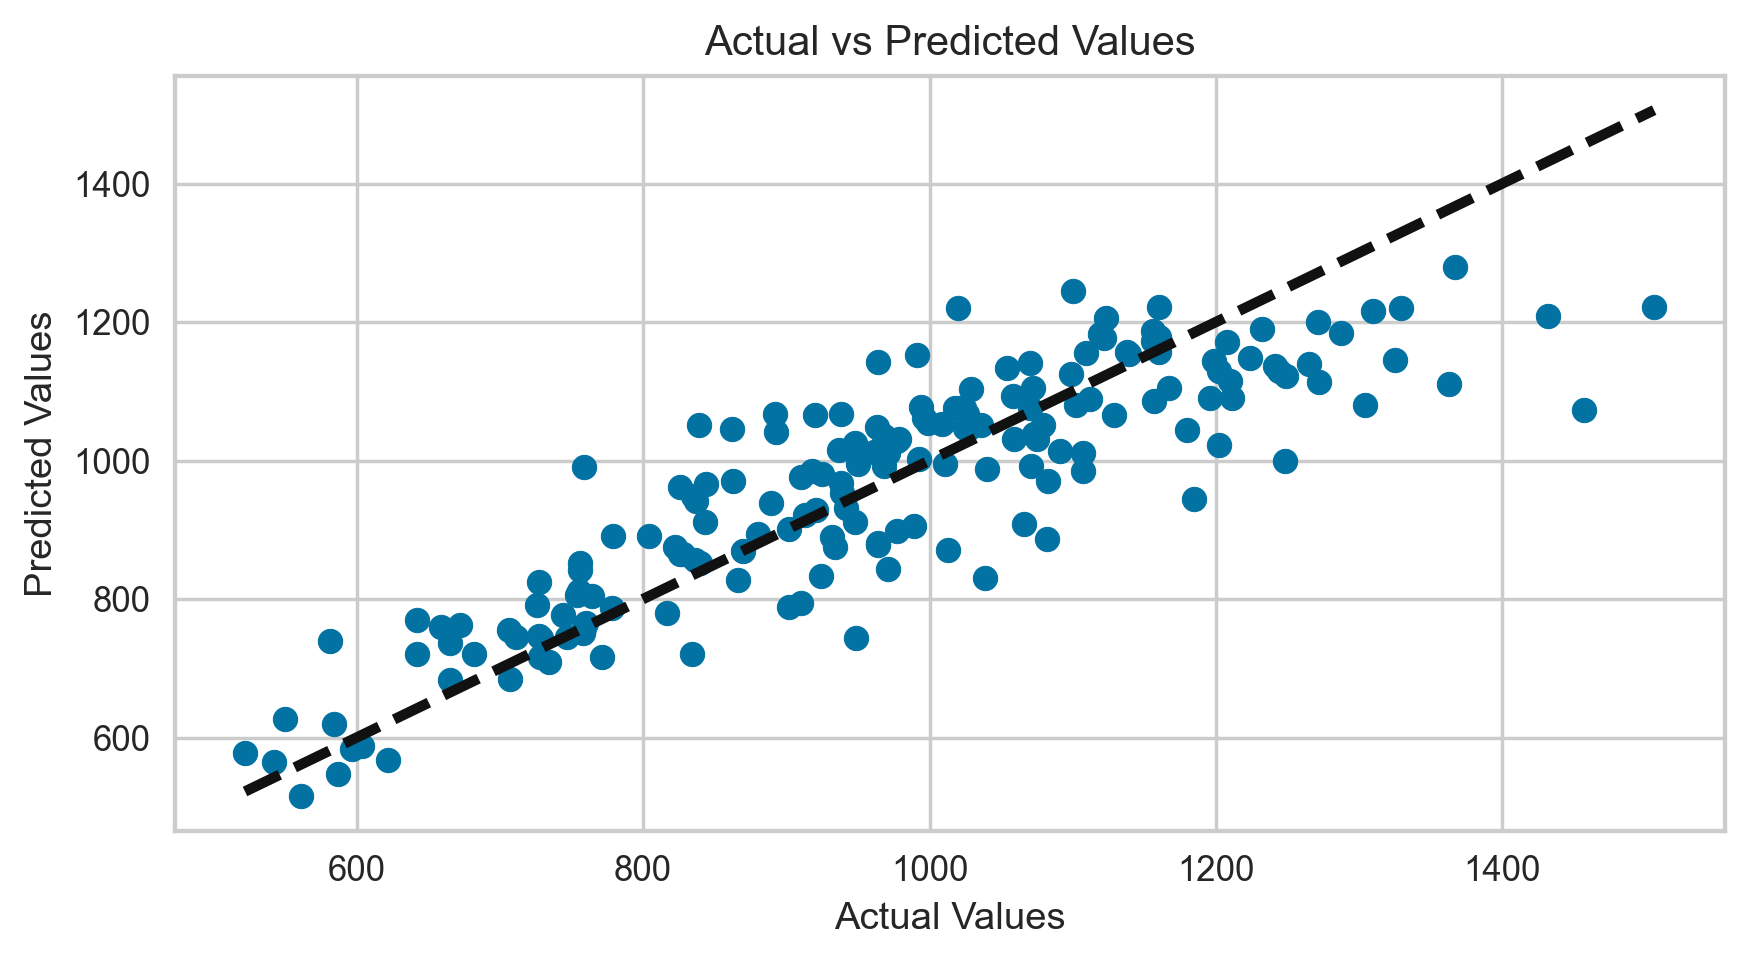

<BarContainer object of 3 artists>

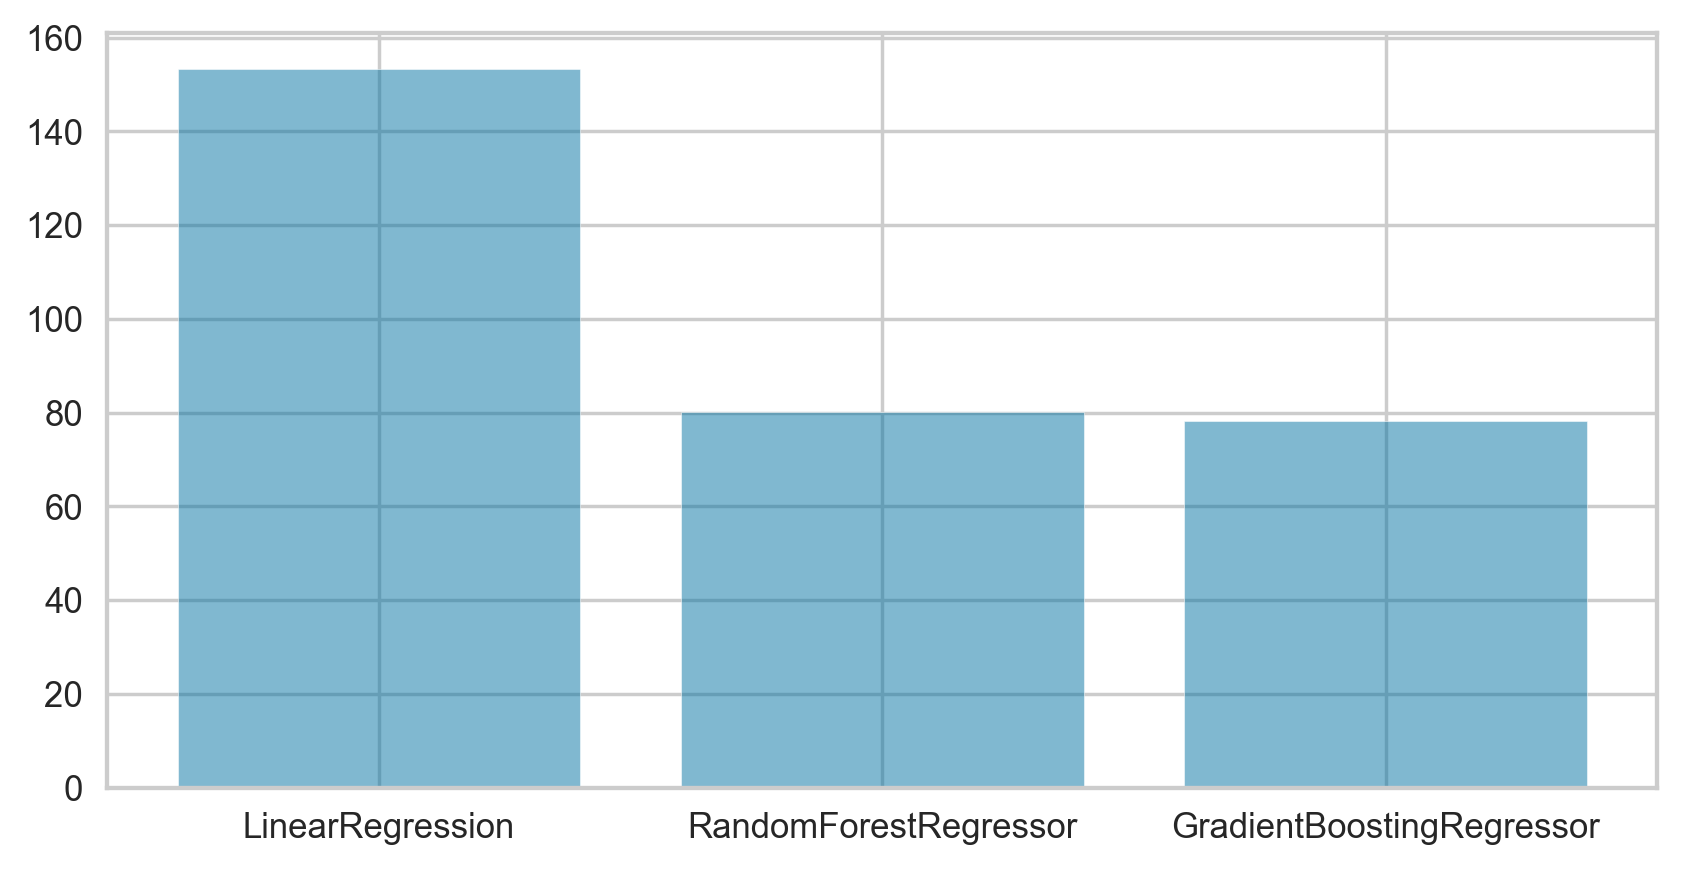

In [ ]:
from sklearn.linear_model import LinearRegression
from matplotlib import ticker

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from yellowbrick.model_selection import LearningCurve

# Define the parameter grids for each model
param_grid_lr = {
    'fit_intercept': [True, False],
    'normalize': [True, False],
    'copy_X': [True, False]
}

param_grid_rfr = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7],
    'max_features': ['sqrt', 'log2']
}

param_grid_gbr = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 1]
}


model_accuracy = {}

# Create a list of tuples containing the models and their respective parameter grids
models = [
    (LinearRegression(), param_grid_lr),
    (RandomForestRegressor(), param_grid_rfr),
    (GradientBoostingRegressor(), param_grid_gbr),
    
]

# Loop through the list of models, and fit each model using GridSearchCV
for model, param_grid in models:
    grid = GridSearchCV(model, param_grid, cv=10, scoring='neg_mean_absolute_error' , n_jobs=-1)
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)
    best_model = grid.best_estimator_
    sizes = np.linspace(0.3, 1.0, 10)
    lc_viz = LearningCurve(best_model, scoring='neg_mean_absolute_error', train_sizes=sizes, n_jobs=-1)
    lc_viz.fit(X_train, y_train)
    lc_viz.show()

    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    print(model.__class__.__name__)
    print("Best hyperparameters: ", grid.best_params_)
    print("Best score: ", -grid.best_score_)
    print("Test MAE: {:.3f}".format(mae))
    print("Test MAPE: {:.3f}%".format(mape*100))
    print("Test RMSE: {:.3f}".format(rmse))
    print("Test R^2: {:.3f}".format(r2))
    print("="*50)
    
    # Store accuracy metrics in dictionary
    model_accuracy[model.__class__.__name__] = {"MAE": mae, "MAPE": mape, "RMSE": rmse, "R^2": r2}
    
    # Create bar plot of actual vs predicted values
    fig, ax = plt.subplots(figsize=(8,4), dpi=250)
    sns.barplot(x=np.arange(len(y_test)), y=y_test, color='b', alpha=0.5, label='Actual', ax=ax)
    sns.barplot(x=np.arange(len(y_test)), y=y_pred, color='r', alpha=0.5, label='Predicted', ax=ax)
    ax.set(xlabel='Sample', ylabel='Value', title=model.__class__.__name__)
    ax.legend()
    # Set y-axis tick locator to show every 5 minutes
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    plt.show()
    
    # Create actual vs predicted plot
    plt.figure(1,(8,4),dpi = 250)
    plt.scatter(y_test, y_pred)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=3)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values')
    plt.show()

# Create bar plot of accuracy metrics for each model
fig, ax = plt.subplots(figsize=(8,4), dpi=250)
model_names = list(model_accuracy.keys())
mae_scores = [model_accuracy[model]["MAE"] for model in model_names]
mape_scores = [model_accuracy[model]["MAPE"] for model in model_names]
rmse_scores = [model_accuracy[model]["RMSE"] for model in model_names]
r2_scores = [model_accuracy[model]["R^2"] for model in model_names]
ax.bar(model_names, mae_scores, alpha=0.5, label="MAE")

In [ ]:
conditions=weather.conditions.unique()
print(len(conditions),conditions)


7 ['Partially cloudy' 'Clear' 'Snow, Rain, Partially cloudy'
 'Rain, Partially cloudy' 'Overcast' 'Rain, Overcast'
 'Snow, Rain, Overcast']


In [ ]:
features=['time','stopname','VehicleId','VehicleId1','shour','stopname1','direction',
          'time_of_day','weekday','daytype','date','temp', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob',
       'snow', 'snowdepth', 'windgust', 'winddir', 'windspeed', 'cloudcover',
       'conditions', 'icon']
X = onewaytime[features]
y = onewaytime['duration']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.07,shuffle=True, random_state=42)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce t

LinearRegression
Best hyperparameters:  {'copy_X': True, 'fit_intercept': True, 'normalize': False}
Best score:  37087.870079026674
Test MAE: 153.405
Test MAPE: 17.791%
Test RMSE: 198.039
Test R^2: 0.052


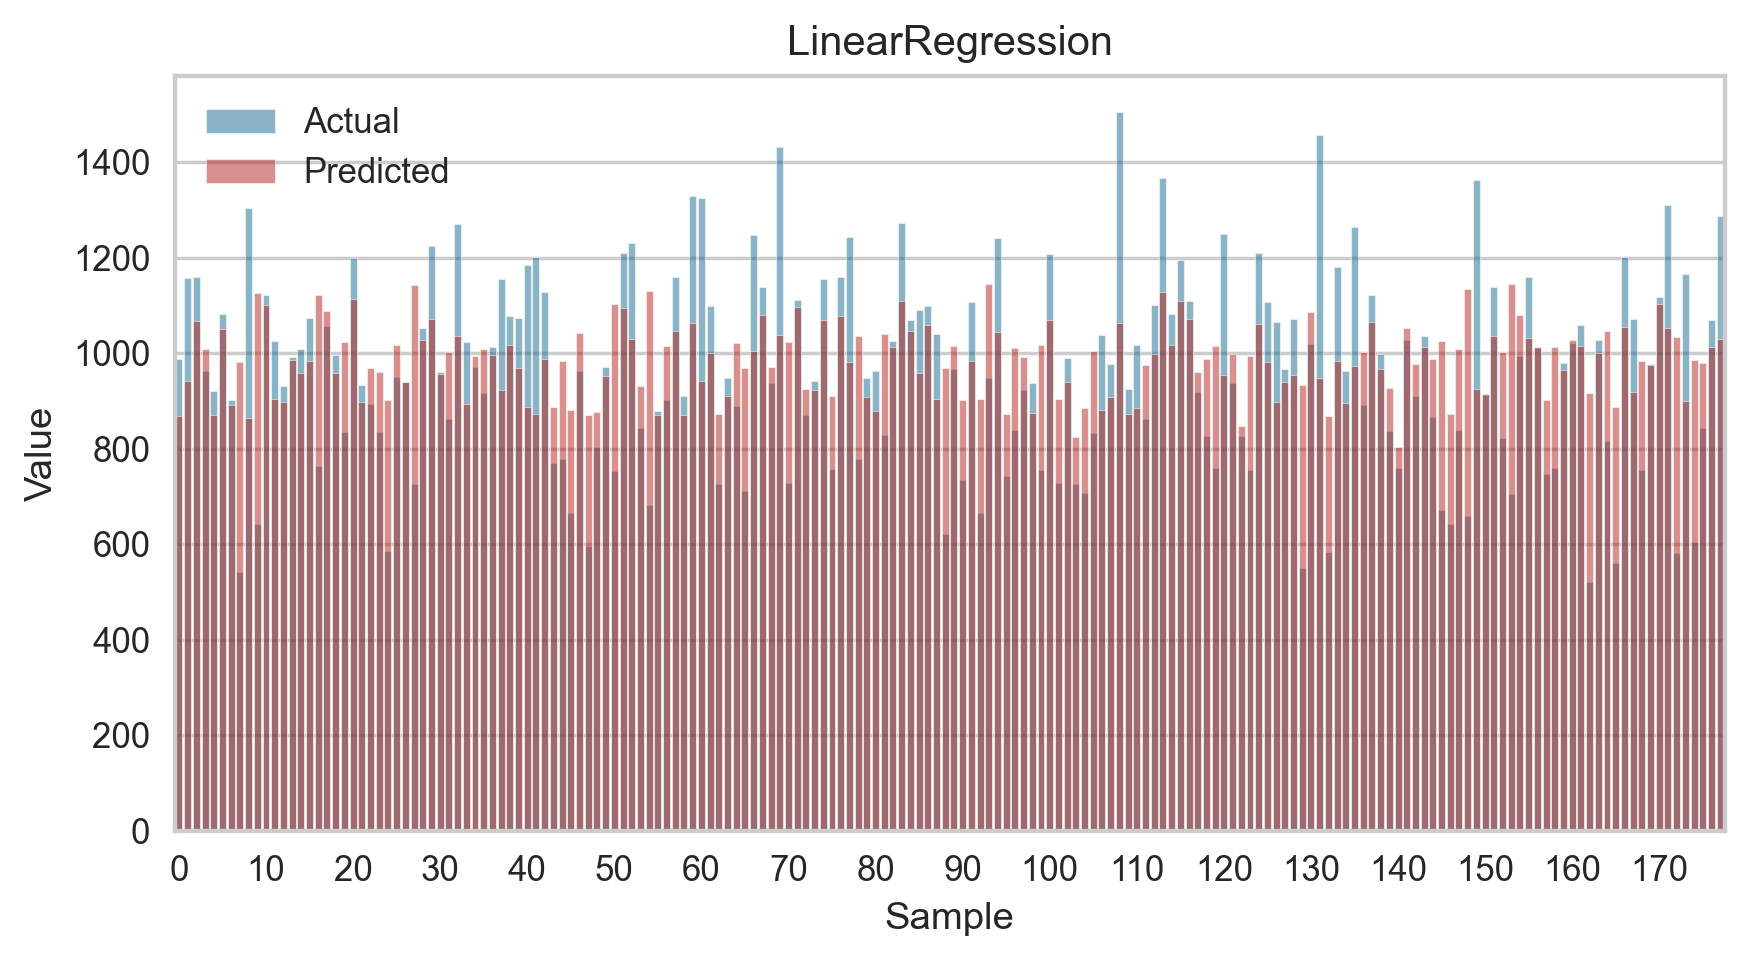

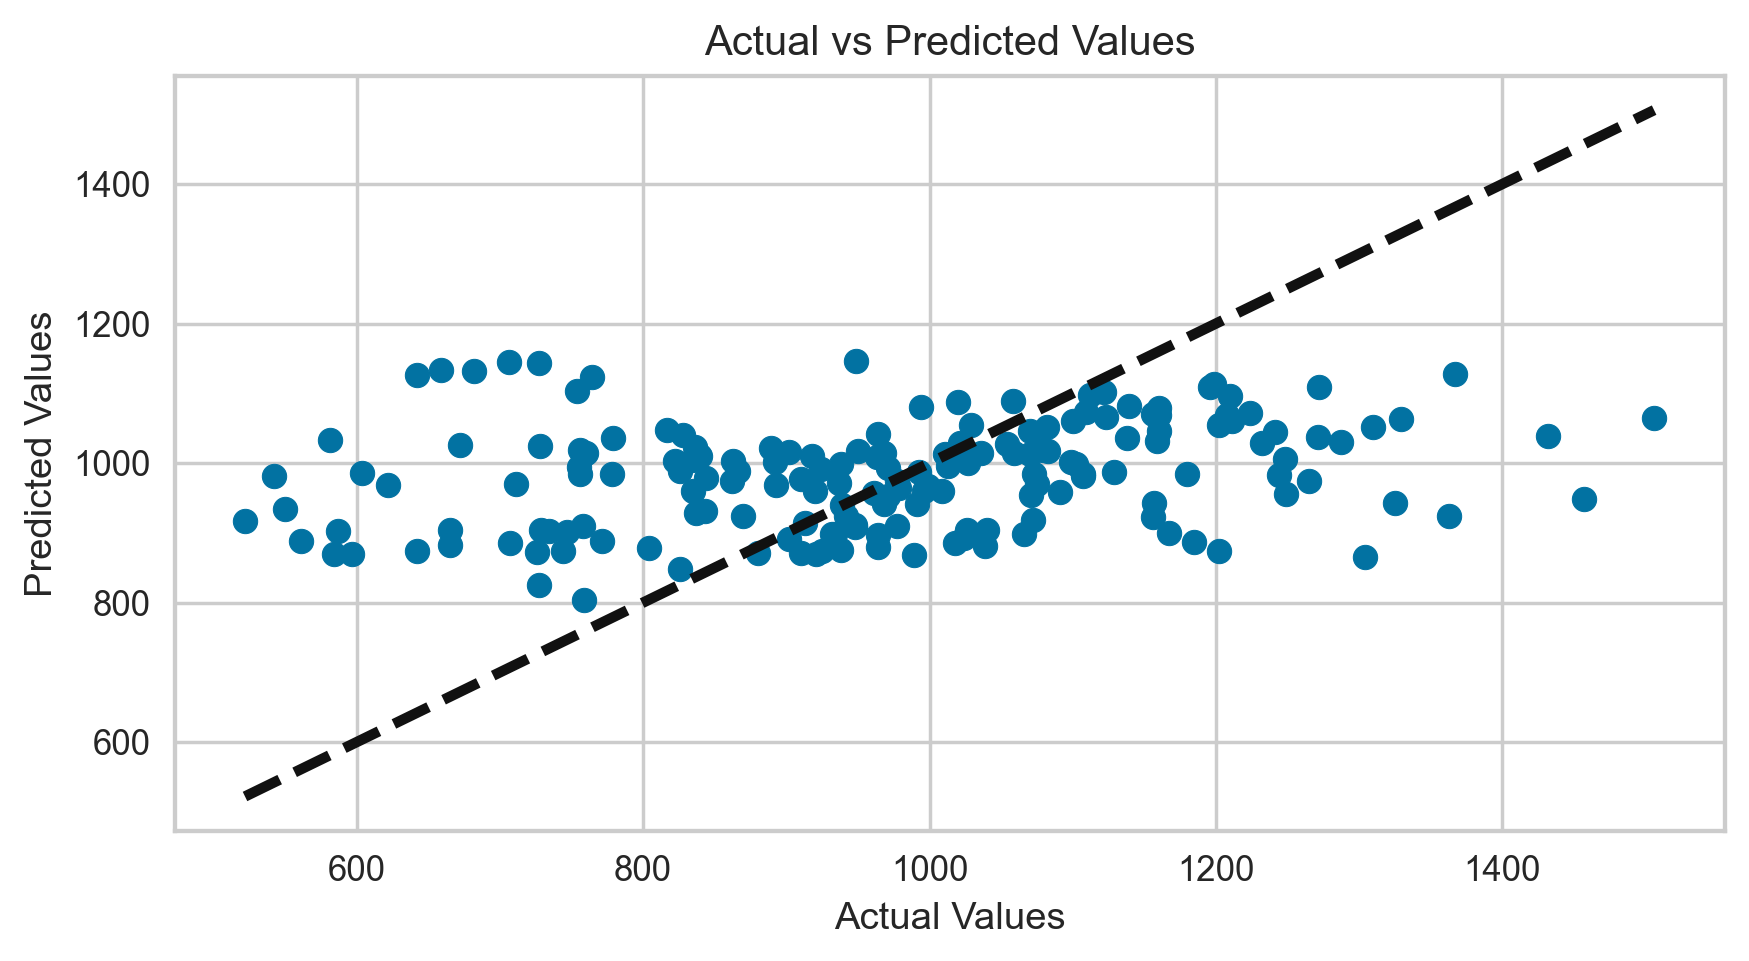

RandomForestRegressor
Best hyperparameters:  {'max_depth': 7, 'max_features': 'log2', 'n_estimators': 1000}
Best score:  15085.983192336218
Test MAE: 80.424
Test MAPE: 8.287%
Test RMSE: 104.493
Test R^2: 0.736


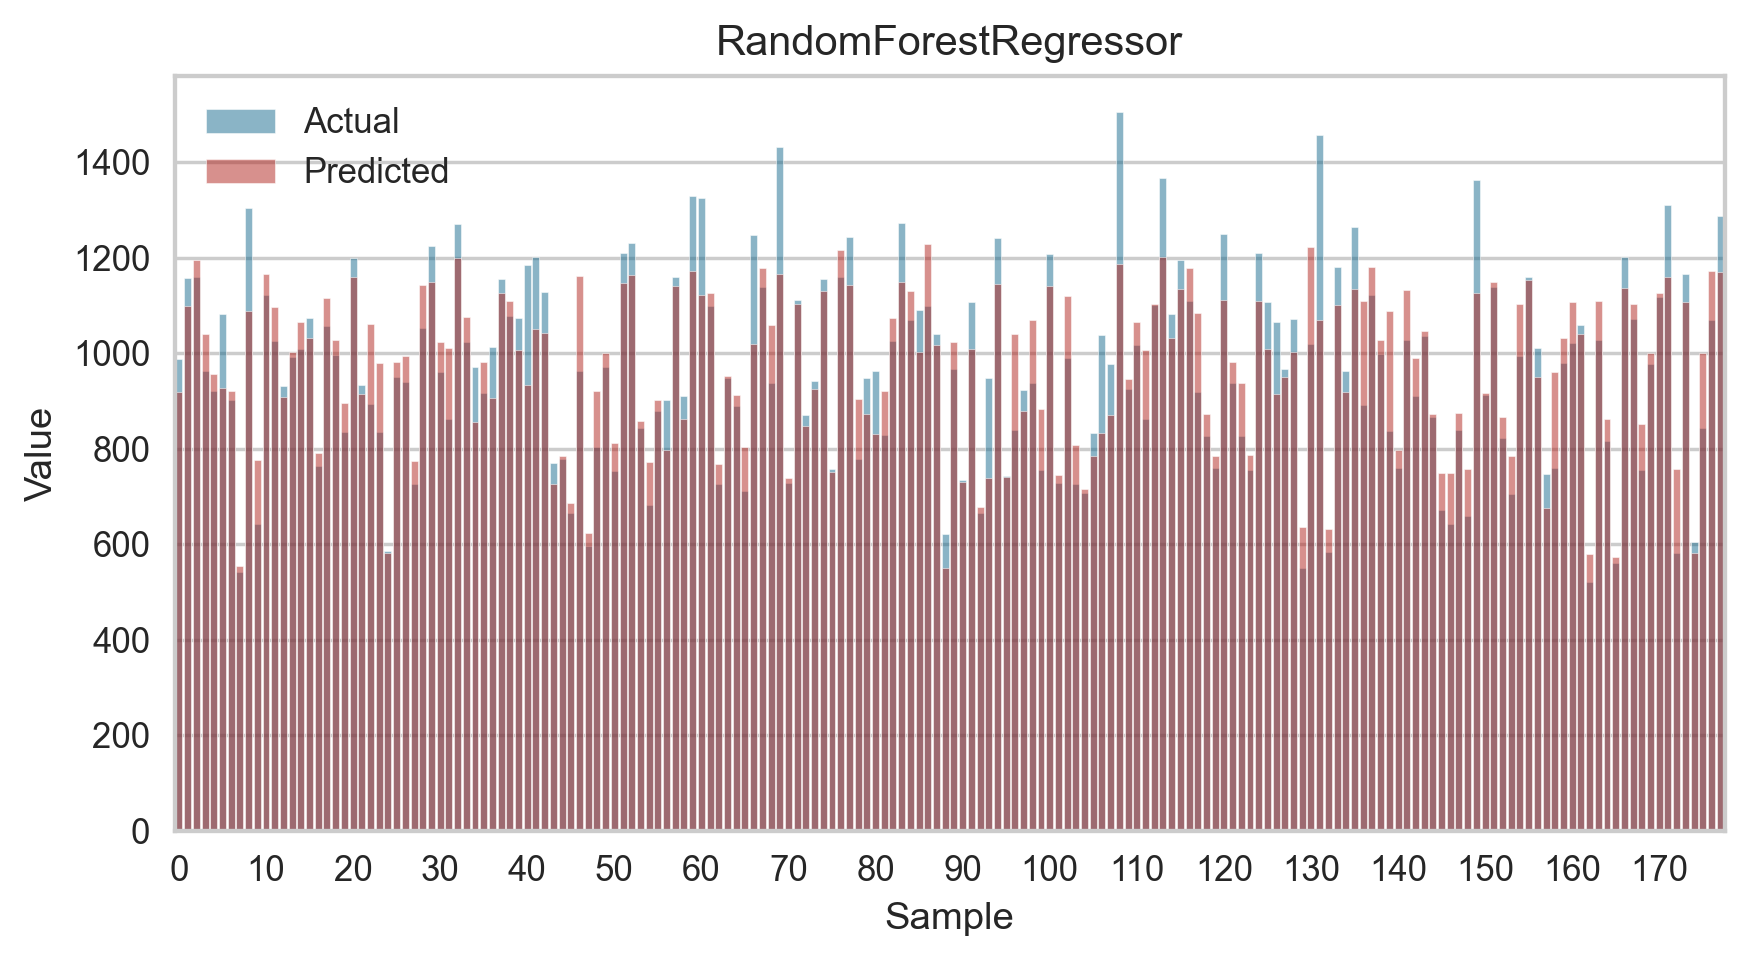

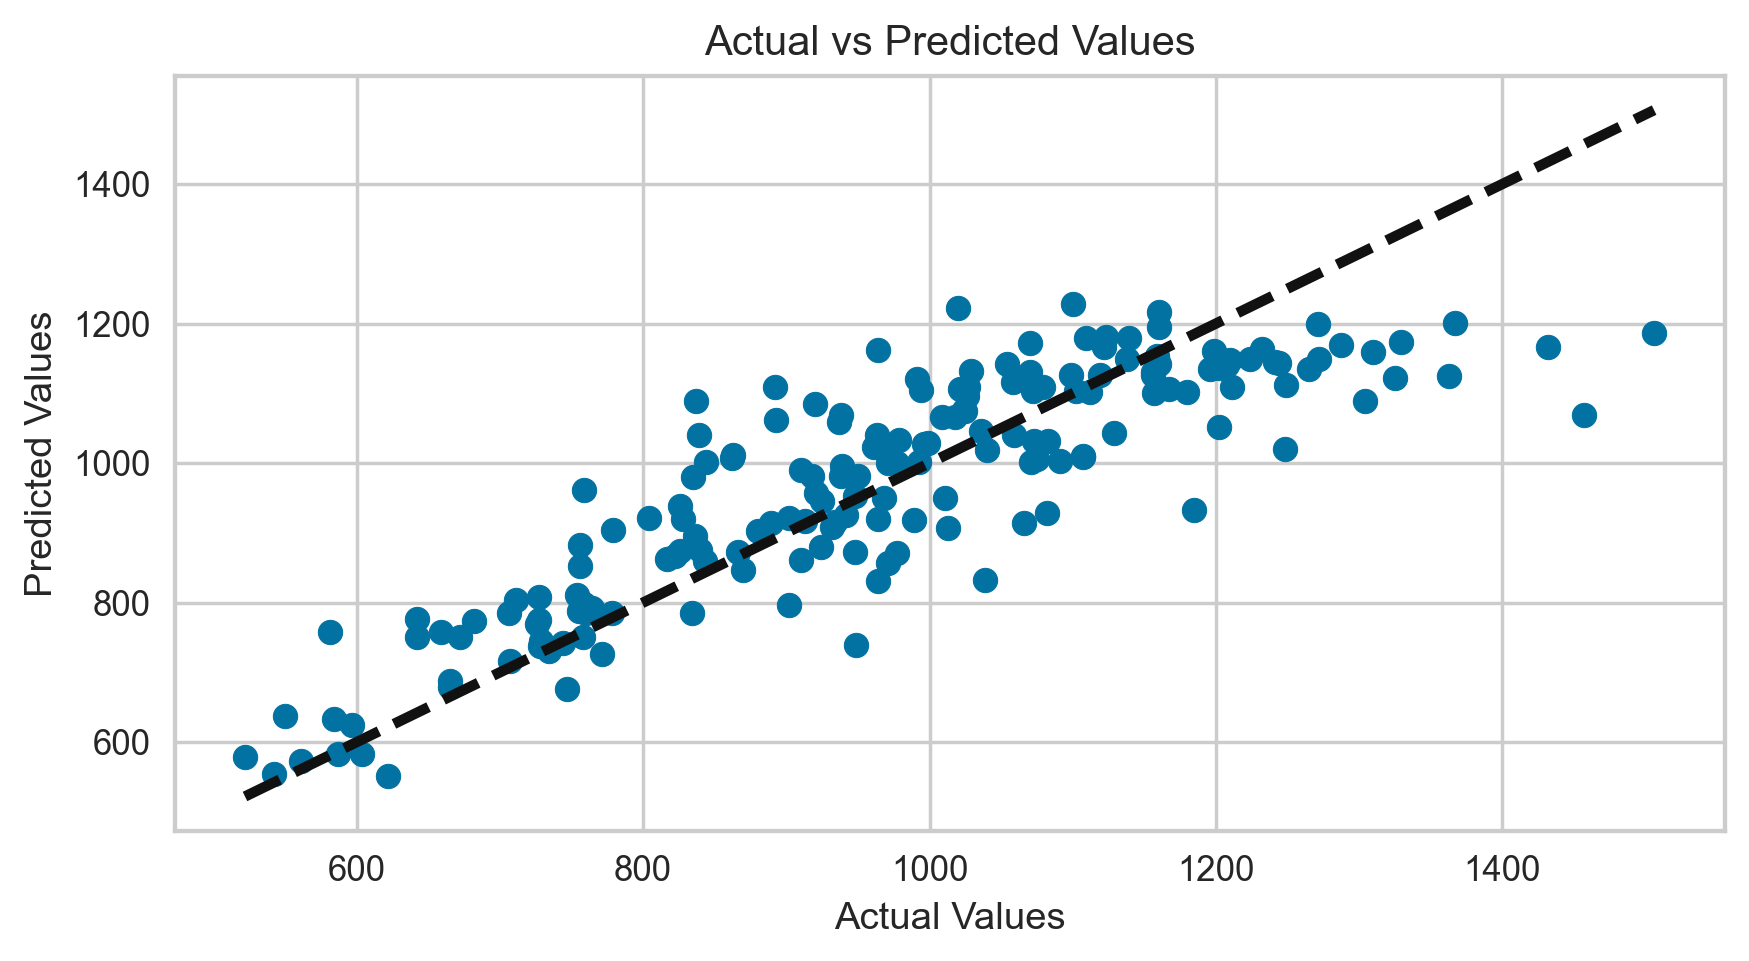

GradientBoostingRegressor
Best hyperparameters:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000}
Best score:  14545.797780781611
Test MAE: 78.198
Test MAPE: 8.034%
Test RMSE: 101.000
Test R^2: 0.753


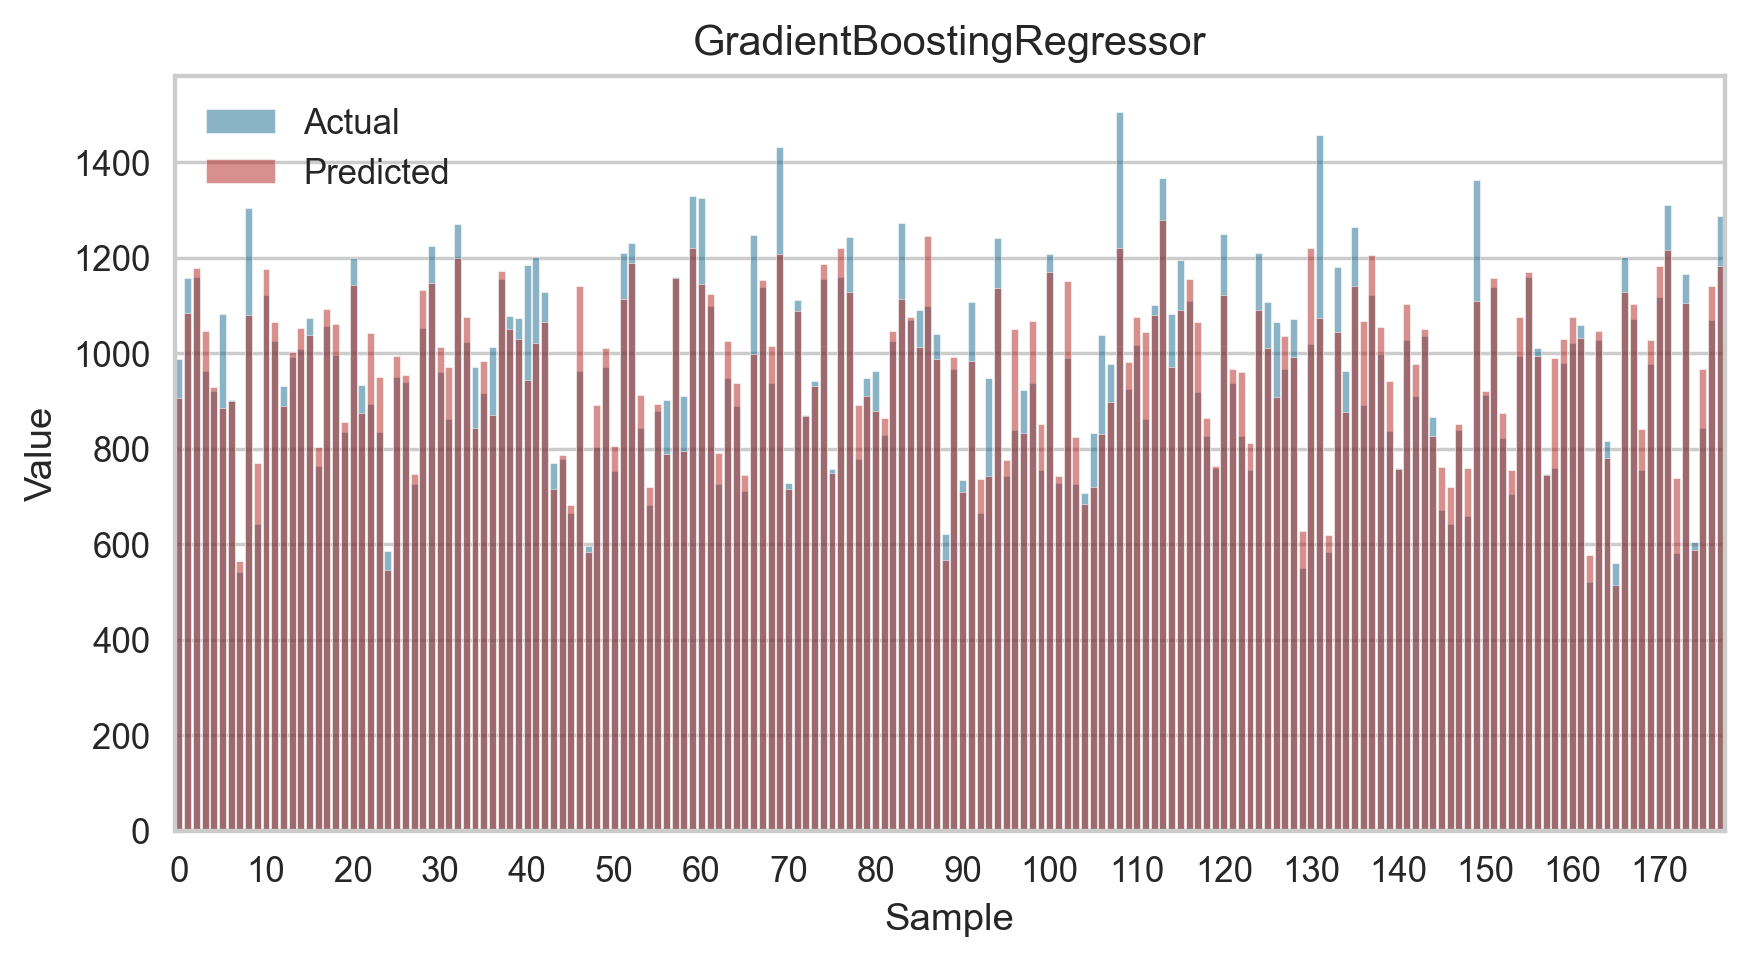

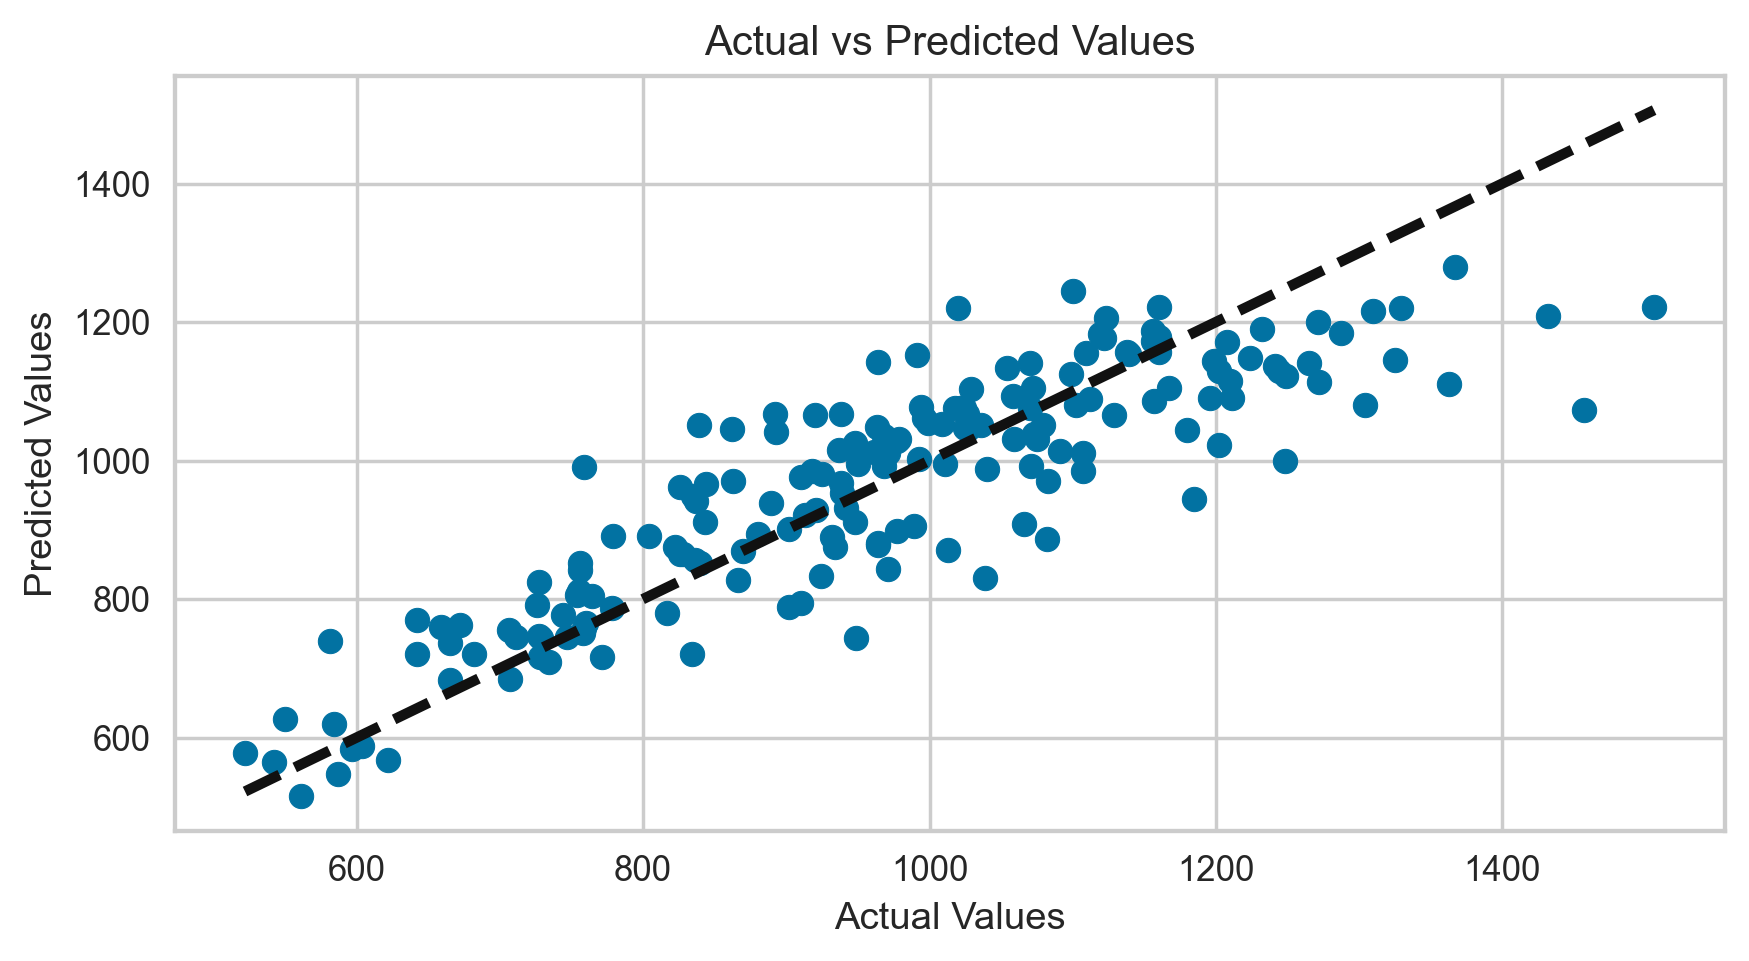

<BarContainer object of 3 artists>

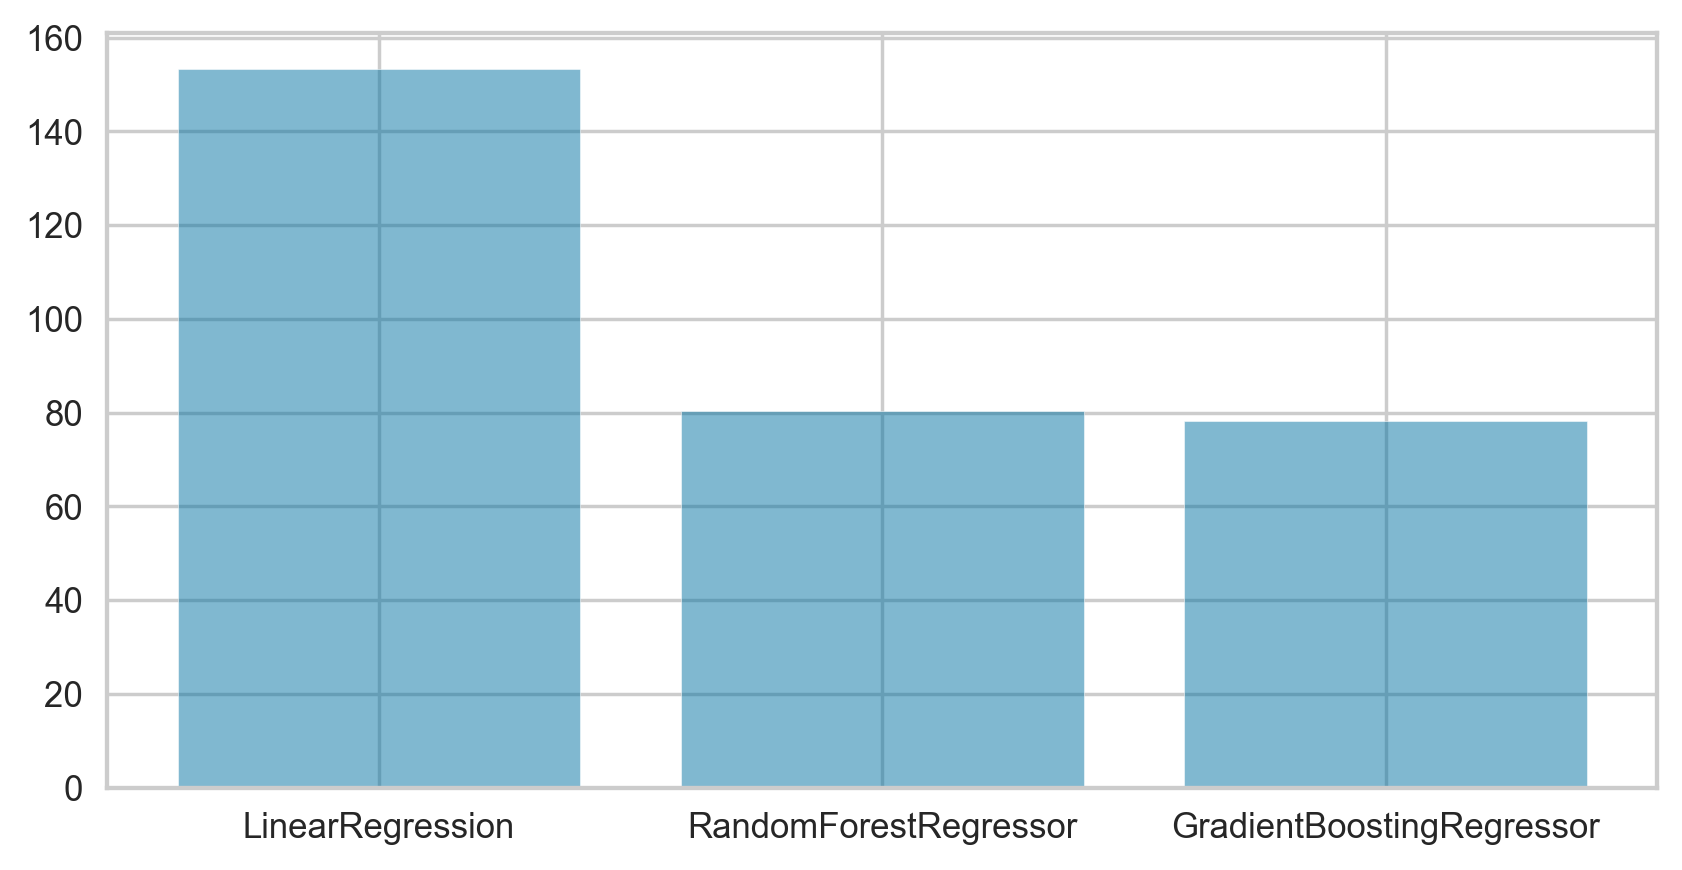

In [ ]:
# Define the parameter grids for each model
param_grid_lr = {
    'fit_intercept': [True, False],
    'normalize': [True, False],
    'copy_X': [True, False]
}

param_grid_rfr = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7],
    'max_features': ['sqrt', 'log2']
}

param_grid_gbr = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 1]
}

param_grid_xgb = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 1]
}

param_grid_catboost = {
    'iterations': [100, 500, 1000],
    'depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 1]
}

param_grid_svm = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.1, 1, 10]
}

model_accuracy = {}

# Create a list of tuples containing the models and their respective parameter grids
models = [
    (LinearRegression(), param_grid_lr),
    (RandomForestRegressor(), param_grid_rfr),
    (GradientBoostingRegressor(), param_grid_gbr),
    
]

# Loop through the list of models, and fit each model using GridSearchCV
for model, param_grid in models:
    grid = GridSearchCV(model, param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    print(model.__class__.__name__)
    print("Best hyperparameters: ", grid.best_params_)
    print("Best score: ", -grid.best_score_)
    print("Test MAE: {:.3f}".format(mae))
    print("Test MAPE: {:.3f}%".format(mape*100))
    print("Test RMSE: {:.3f}".format(rmse))
    print("Test R^2: {:.3f}".format(r2))
    print("="*50)
    
    # Store accuracy metrics in dictionary
    model_accuracy[model.__class__.__name__] = {"MAE": mae, "MAPE": mape, "RMSE": rmse, "R^2": r2}
    
    # Create bar plot of actual vs predicted values
    fig, ax = plt.subplots(figsize=(8,4), dpi=250)
    sns.barplot(x=np.arange(len(y_test)), y=y_test, color='b', alpha=0.5, label='Actual', ax=ax)
    sns.barplot(x=np.arange(len(y_test)), y=y_pred, color='r', alpha=0.5, label='Predicted', ax=ax)
    ax.set(xlabel='Sample', ylabel='Value', title=model.__class__.__name__)
    ax.legend()
    # Set y-axis tick locator to show every 5 minutes
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    plt.show()
    
    # Create actual vs predicted plot
    plt.figure(1,(8,4),dpi = 250)
    plt.scatter(y_test, y_pred)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=3)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values')
    plt.show()

# Create bar plot of accuracy metrics for each model
fig, ax = plt.subplots(figsize=(8,4), dpi=250)
model_names = list(model_accuracy.keys())
mae_scores = [model_accuracy[model]["MAE"] for model in model_names]
mape_scores = [model_accuracy[model]["MAPE"] for model in model_names]
rmse_scores = [model_accuracy[model]["RMSE"] for model in model_names]
r2_scores = [model_accuracy[model]["R^2"] for model in model_names]
ax.bar(model_names, mae_scores, alpha=0.5, label="MAE")

In [ ]:
shour_dummies = pd.get_dummies(onewaytime['shour'], prefix='shour')
onewaytime = pd.concat([onewaytime, shour_dummies], axis=1)


In [ ]:
onewaytime.columns

Index(['time', 'stopname', 'VehicleId', 'time1', 'stopname1', 'VehicleId1',
       'duration', 'shour', 'direction', 'weekday', 'date', 'time_of_day',
       'daytype', 'shour1', 'temp', 'feelslike', 'dew', 'humidity', 'precip',
       'precipprob', 'snow', 'snowdepth', 'windgust', 'winddir', 'windspeed',
       'cloudcover', 'conditions', 'icon', 'shour_5', 'shour_6', 'shour_7',
       'shour_8', 'shour_9', 'shour_10', 'shour_11', 'shour_12', 'shour_13',
       'shour_14', 'shour_15', 'shour_16', 'shour_17', 'shour_18', 'shour_19'],
      dtype='object')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce t

LinearRegression
Best hyperparameters:  {'copy_X': True, 'fit_intercept': True, 'normalize': False}
Best score:  17710.26369293502
Test MAE: 87.055
Test MAPE: 9.281%
Test RMSE: 107.328
Test R^2: 0.676


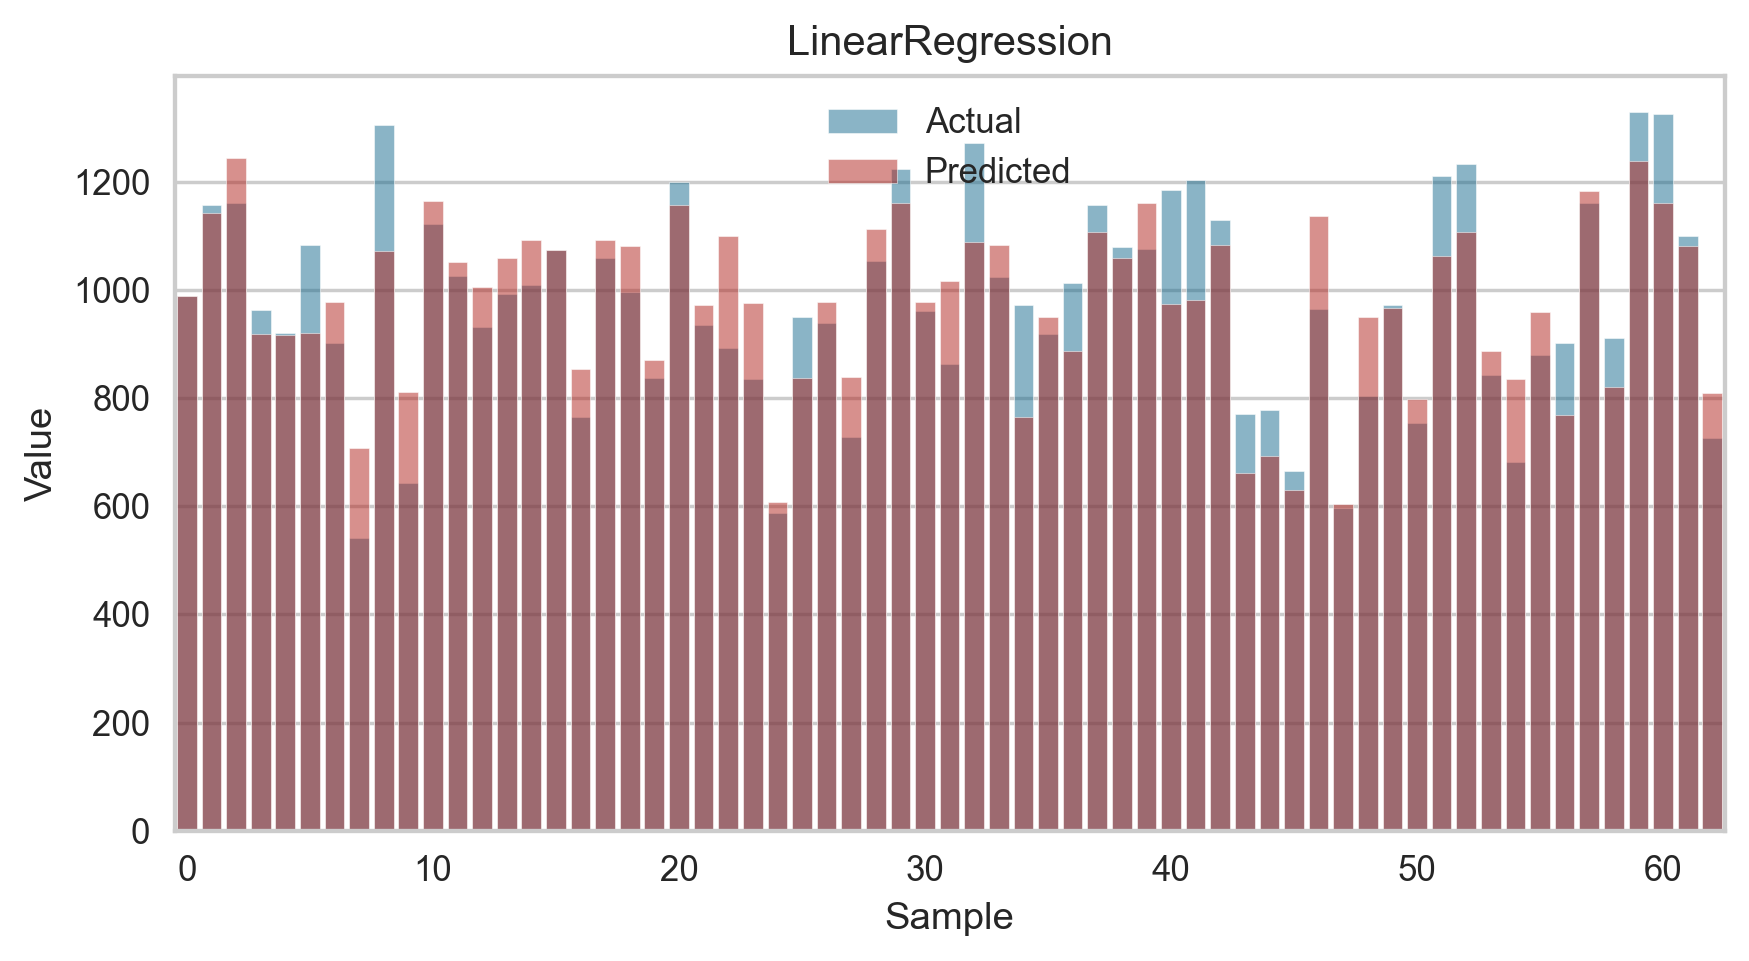

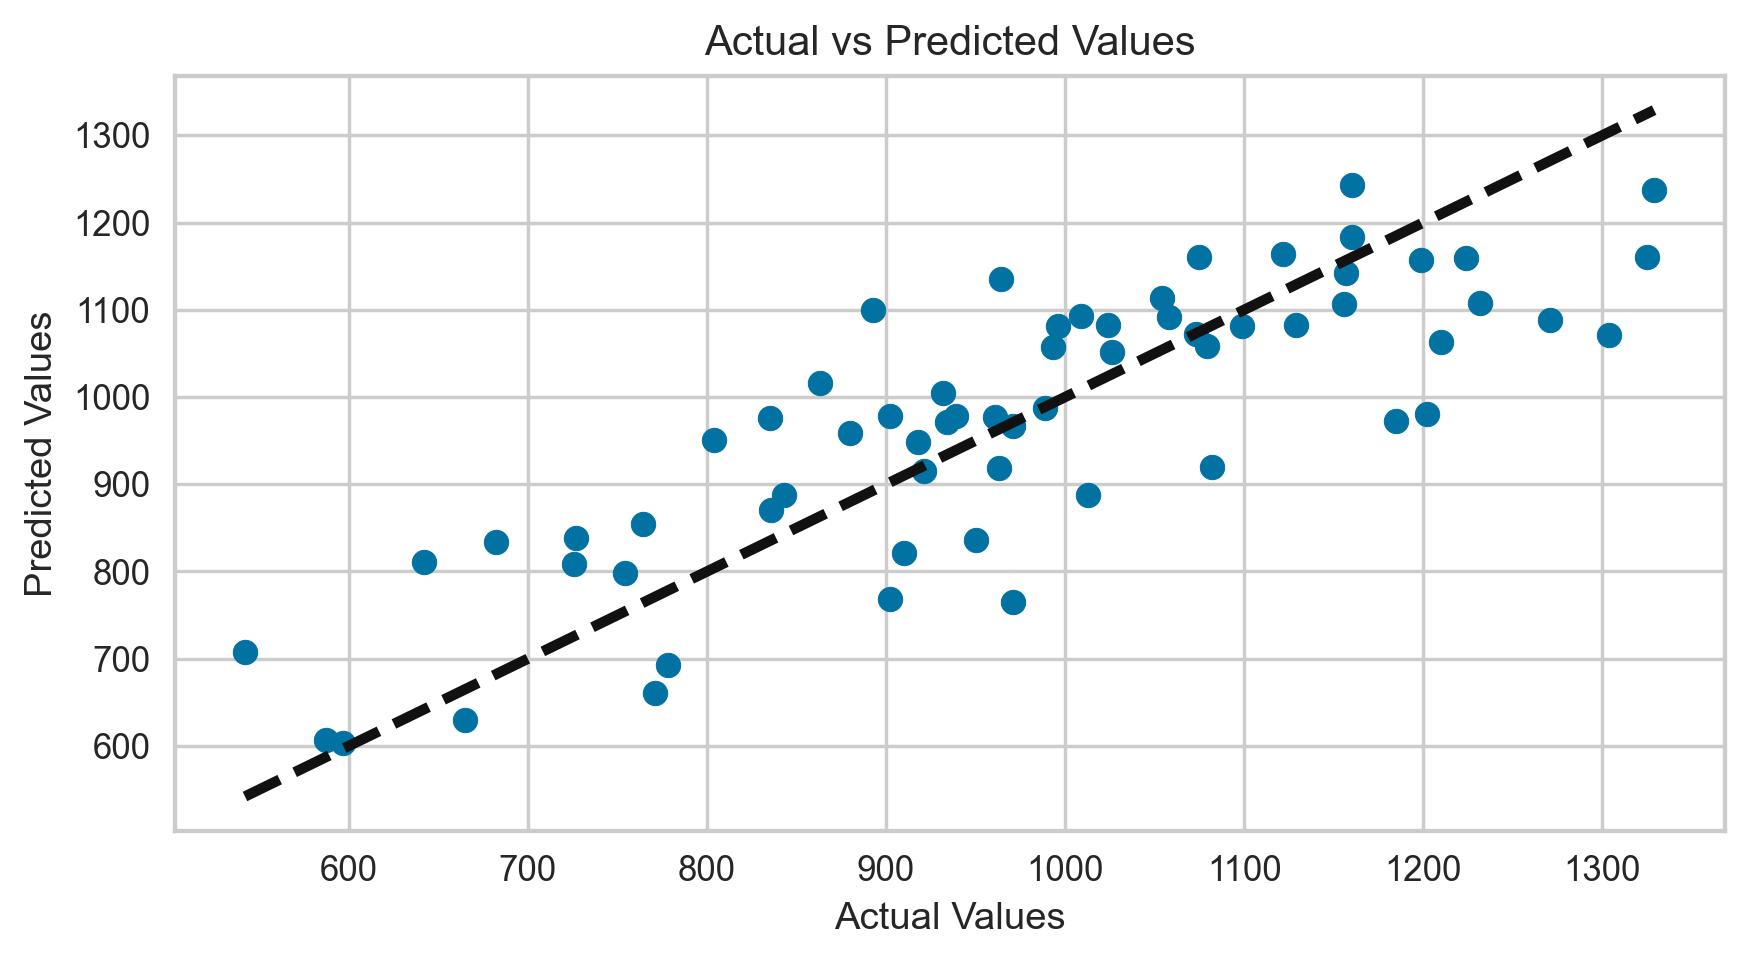

RandomForestRegressor
Best hyperparameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 100}
Best score:  14953.049586765588
Test MAE: 77.661
Test MAPE: 8.125%
Test RMSE: 96.235
Test R^2: 0.740


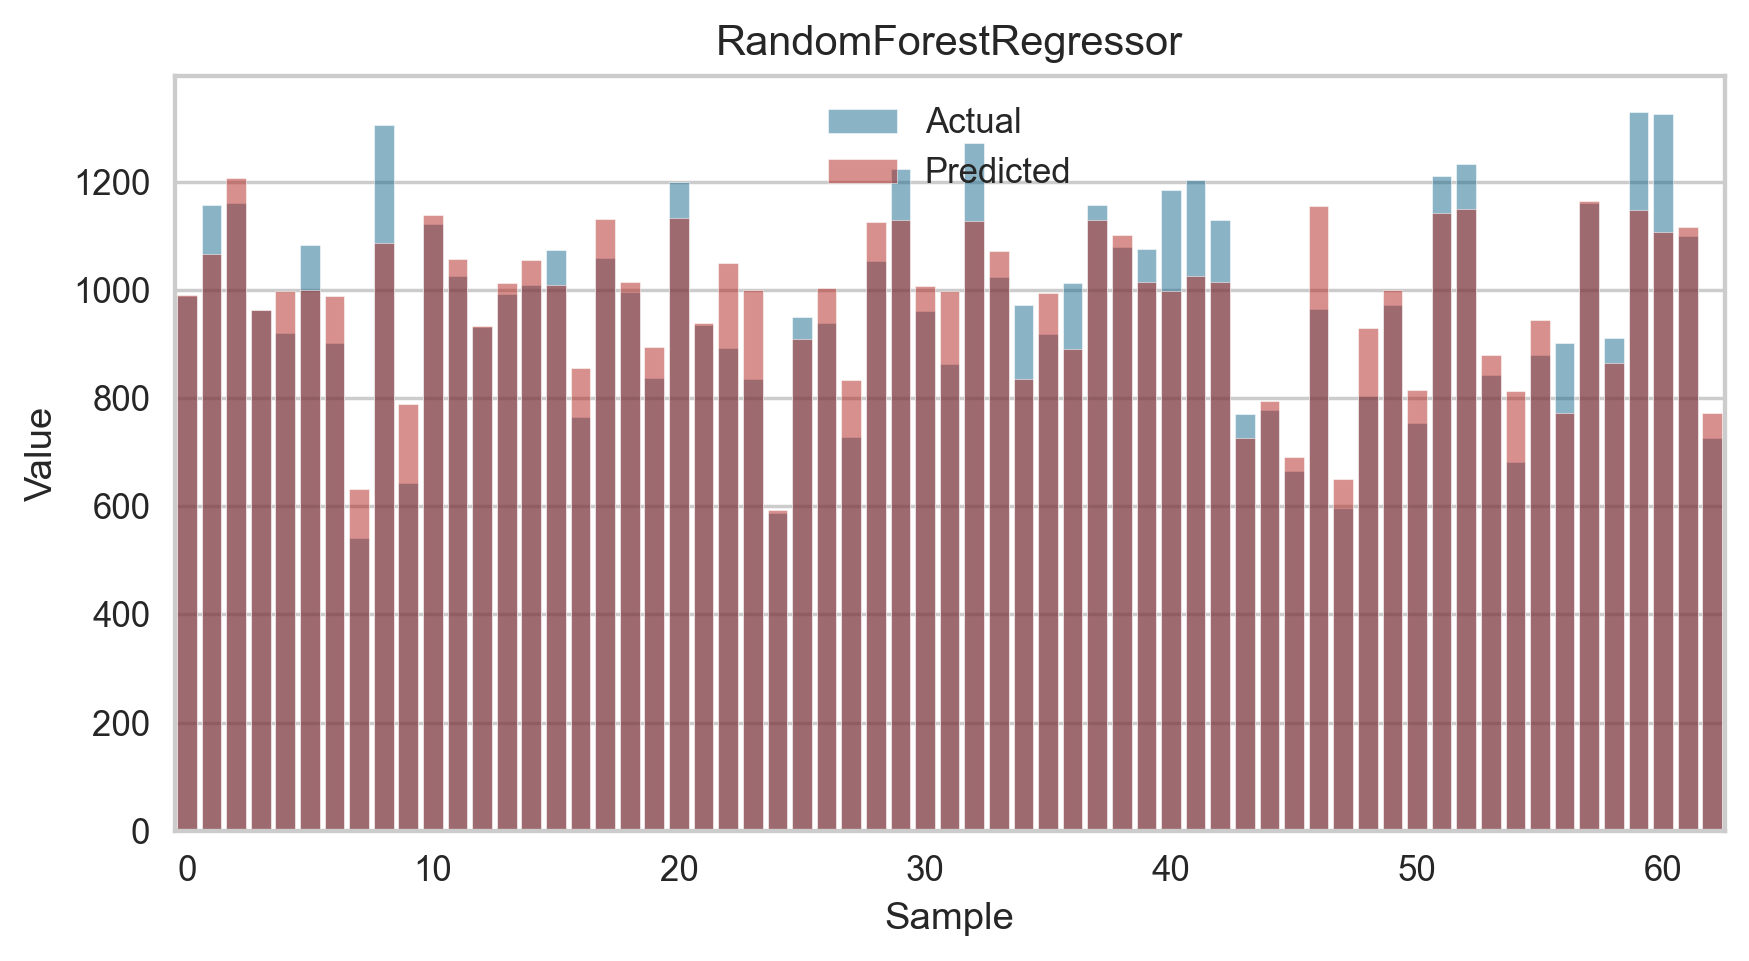

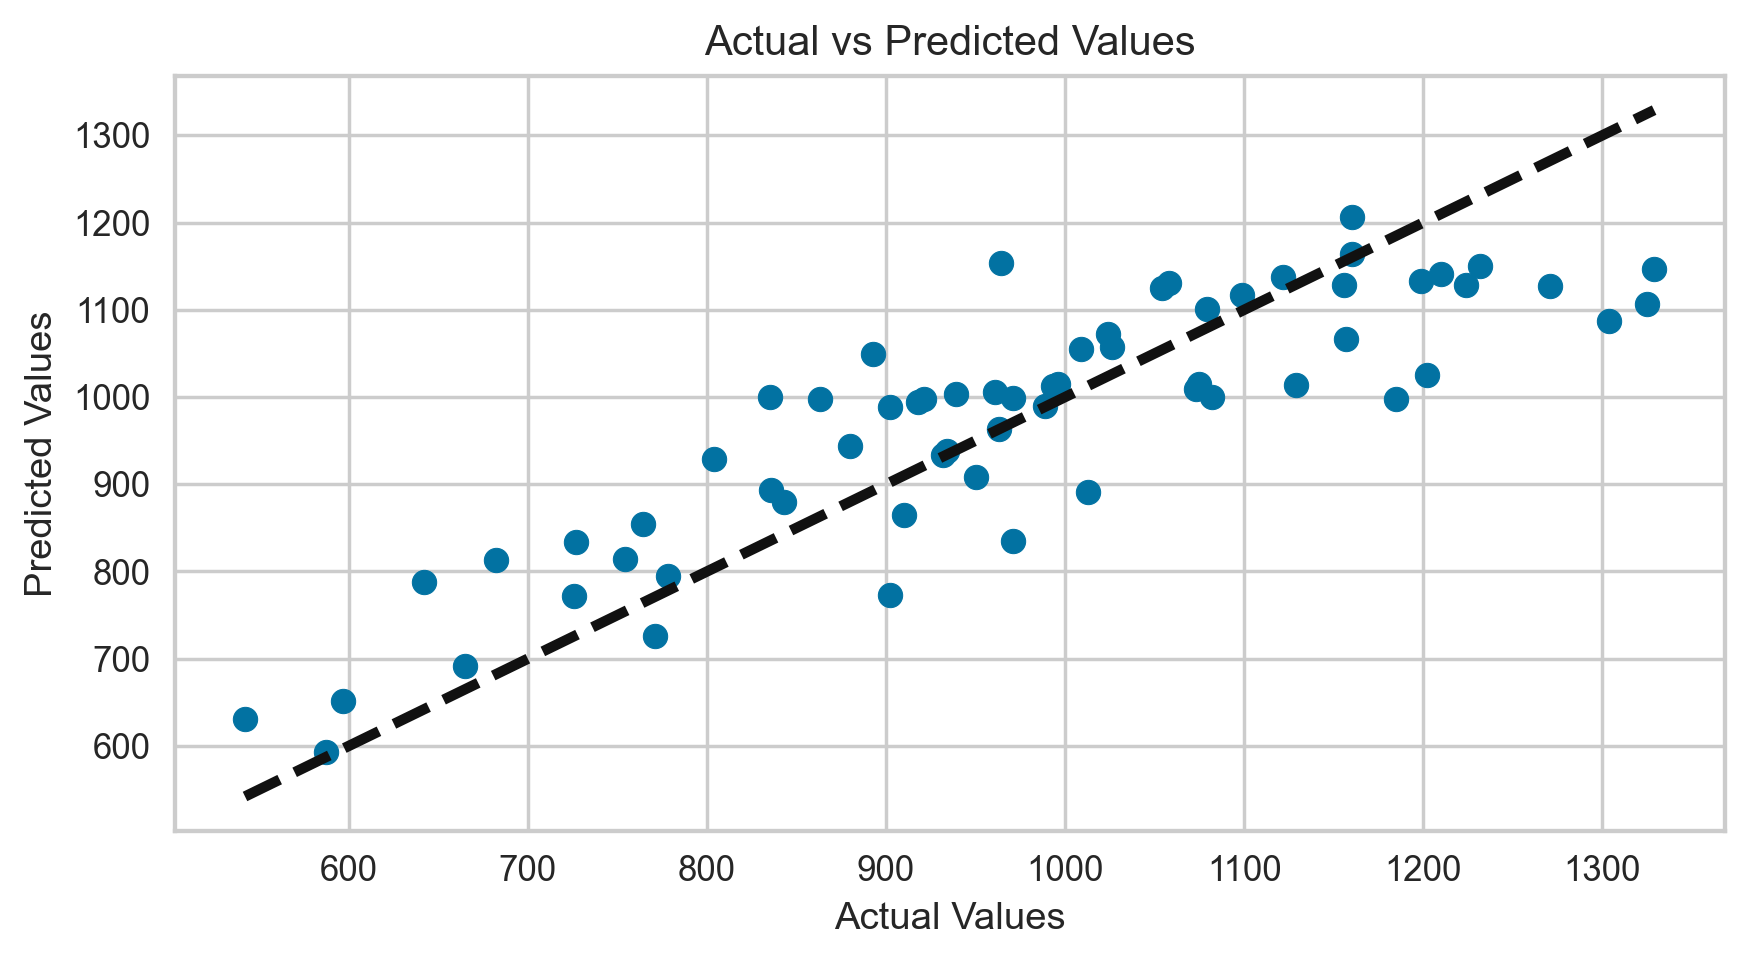

GradientBoostingRegressor
Best hyperparameters:  {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500}
Best score:  14010.163108234041
Test MAE: 72.178
Test MAPE: 7.420%
Test RMSE: 90.429
Test R^2: 0.770


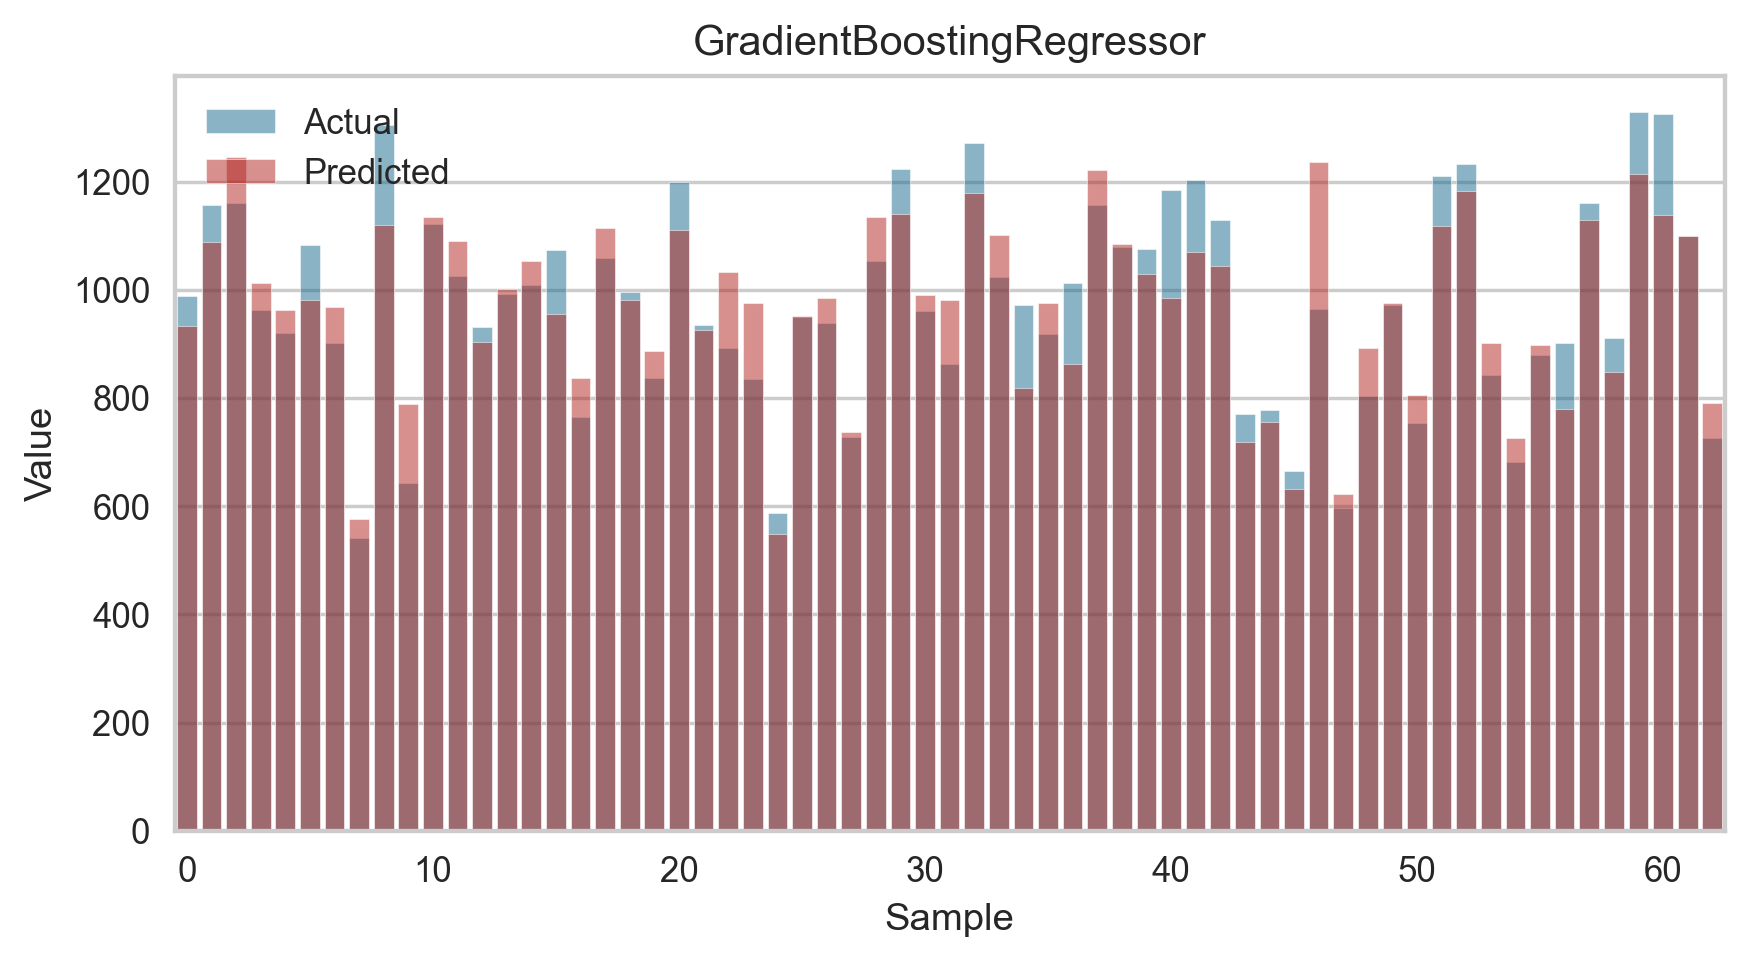

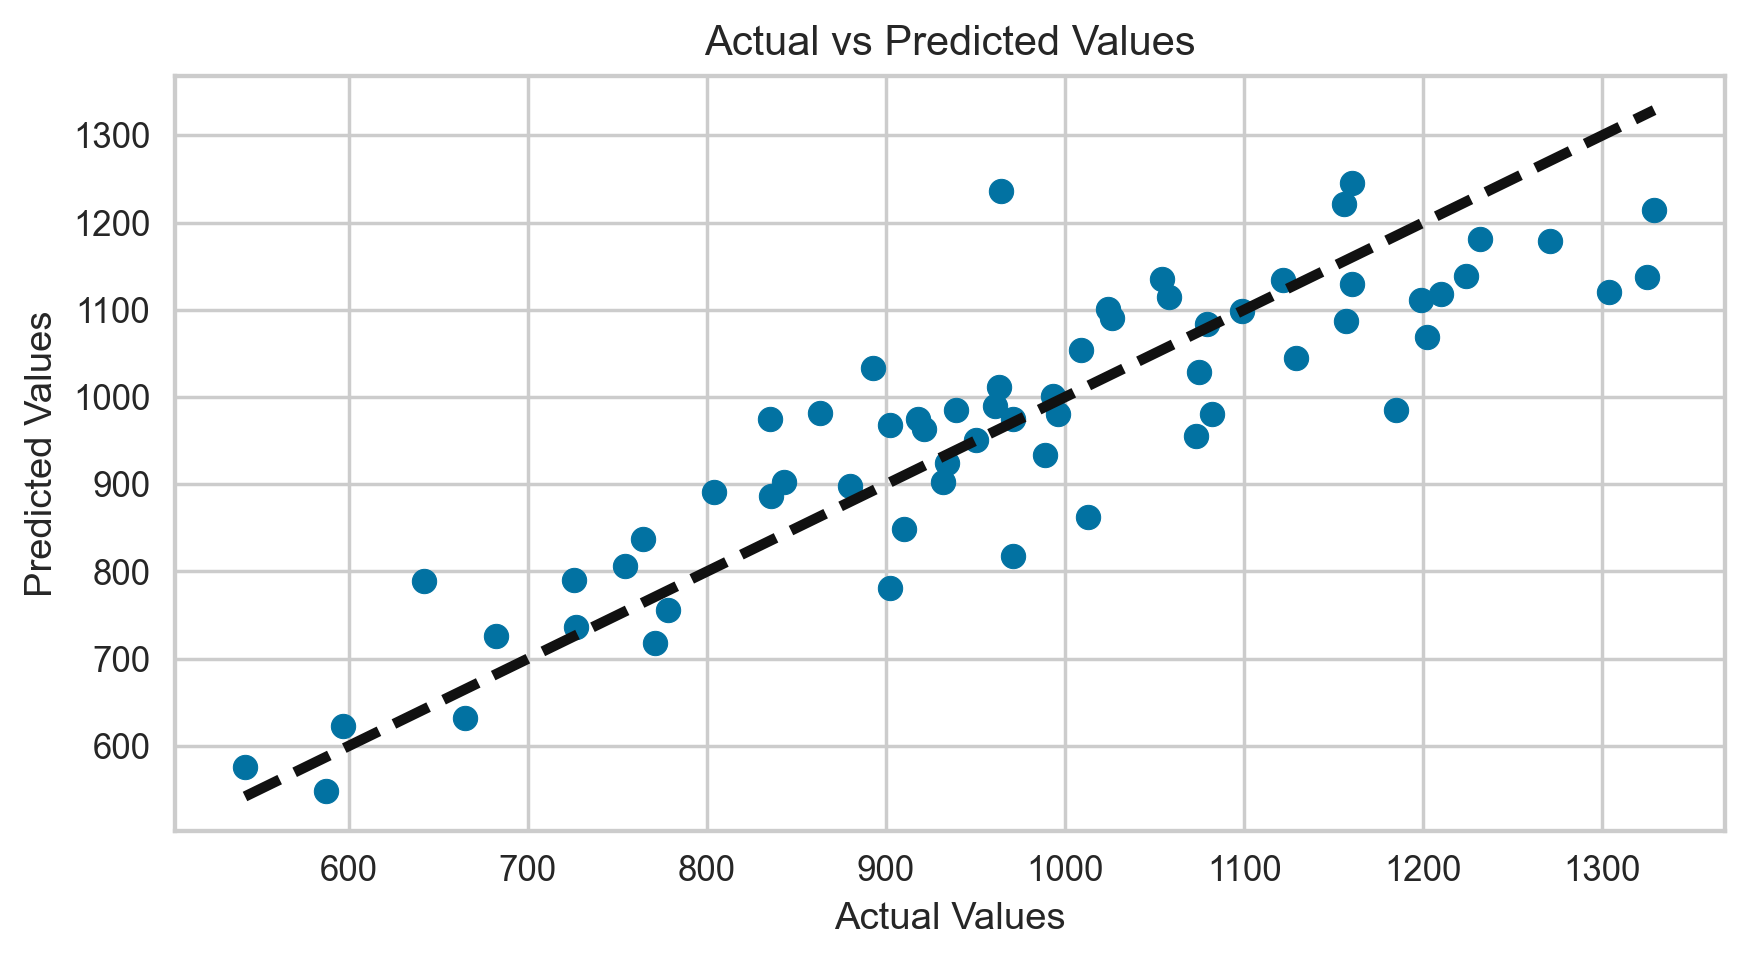

<BarContainer object of 3 artists>

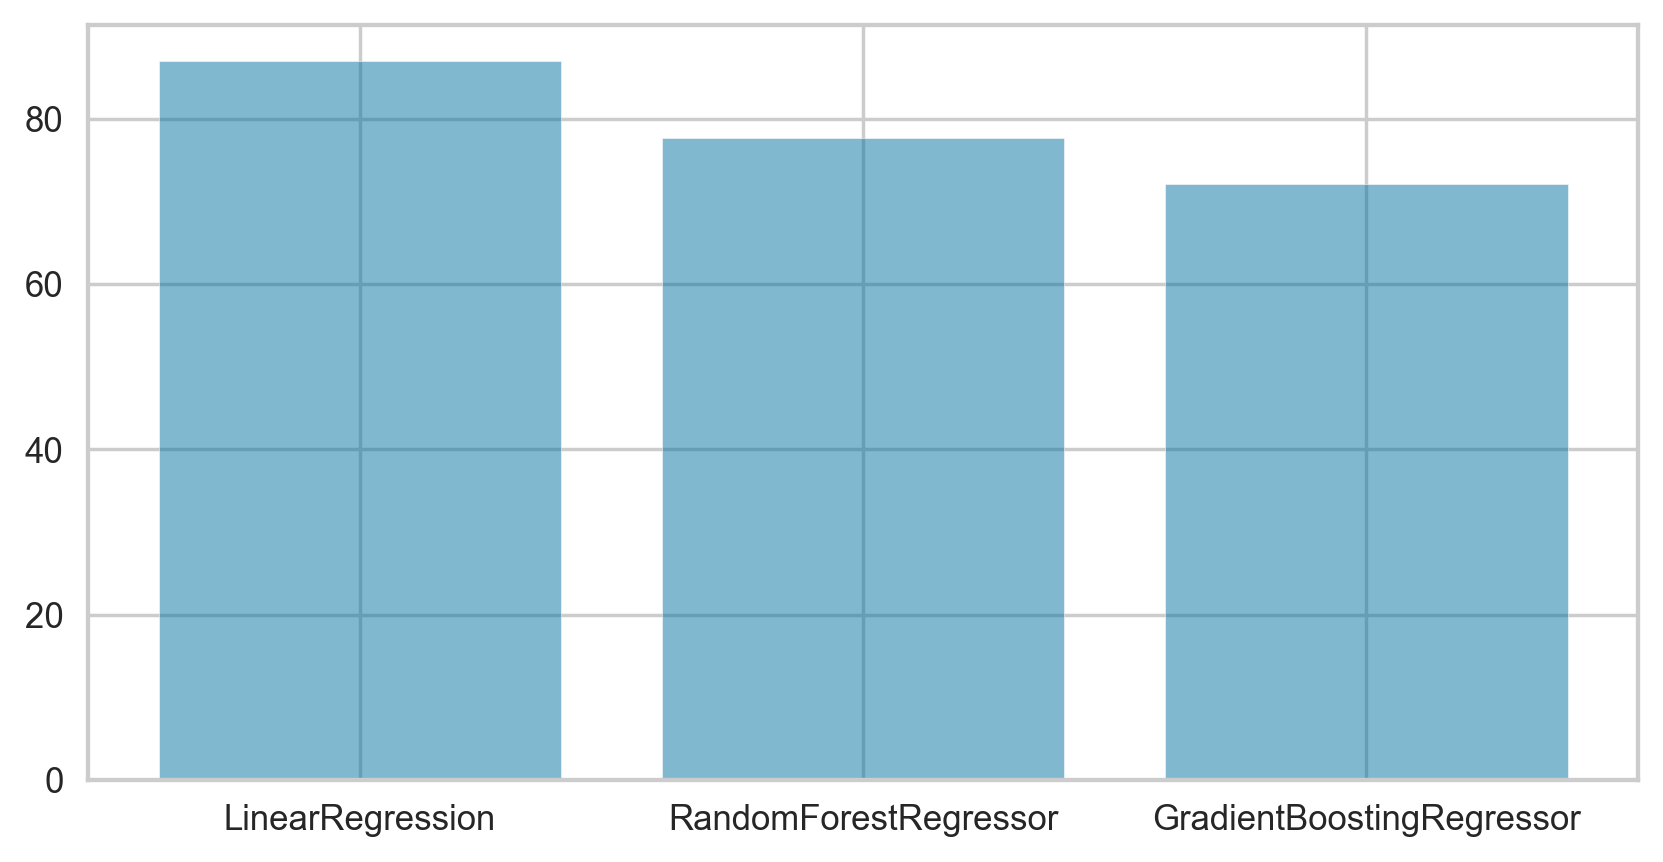

In [ ]:
features=['time','stopname','VehicleId','VehicleId1','shour','stopname1','direction', 'time_of_day','weekday','daytype','date','temp', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob',
       'snow', 'snowdepth', 'windgust', 'winddir', 'windspeed', 'cloudcover', 'conditions', 'icon', 'shour_5', 'shour_6', 'shour_7', 'shour_8', 'shour_9', 'shour_10', 'shour_11', 'shour_12', 'shour_13','shour_14', 'shour_15', 'shour_16', 'shour_17', 'shour_18']
X = onewaytime[features]
y = onewaytime['duration']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.07,shuffle=True, random_state=42)

# Define the parameter grids for each model
param_grid_lr = {
    'fit_intercept': [True, False],
    'normalize': [True, False],
    'copy_X': [True, False]
}

param_grid_rfr = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7],
    'max_features': ['sqrt', 'log2']
}

param_grid_gbr = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 1]
}

param_grid_xgb = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 1]
}

param_grid_catboost = {
    'iterations': [100, 500, 1000],
    'depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 1]
}

param_grid_svm = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.1, 1, 10]
}

model_accuracy = {}

# Create a list of tuples containing the models and their respective parameter grids
models = [
    (LinearRegression(), param_grid_lr),
    (RandomForestRegressor(), param_grid_rfr),
    (GradientBoostingRegressor(), param_grid_gbr),
    
]

# Loop through the list of models, and fit each model using GridSearchCV
for model, param_grid in models:
    grid = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    print(model.__class__.__name__)
    print("Best hyperparameters: ", grid.best_params_)
    print("Best score: ", -grid.best_score_)
    print("Test MAE: {:.3f}".format(mae))
    print("Test MAPE: {:.3f}%".format(mape*100))
    print("Test RMSE: {:.3f}".format(rmse))
    print("Test R^2: {:.3f}".format(r2))
    print("="*50)
    
    # Store accuracy metrics in dictionary
    model_accuracy[model.__class__.__name__] = {"MAE": mae, "MAPE": mape, "RMSE": rmse, "R^2": r2}
    
    # Create bar plot of actual vs predicted values
    fig, ax = plt.subplots(figsize=(8,4), dpi=250)
    sns.barplot(x=np.arange(len(y_test)), y=y_test, color='b', alpha=0.5, label='Actual', ax=ax)
    sns.barplot(x=np.arange(len(y_test)), y=y_pred, color='r', alpha=0.5, label='Predicted', ax=ax)
    ax.set(xlabel='Sample', ylabel='Value', title=model.__class__.__name__)
    ax.legend()
    # Set y-axis tick locator to show every 5 minutes
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    plt.show()
    
    # Create actual vs predicted plot
    plt.figure(1,(8,4),dpi = 250)
    plt.scatter(y_test, y_pred)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=3)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values')
    plt.show()

# Create bar plot of accuracy metrics for each model
fig, ax = plt.subplots(figsize=(8,4), dpi=250)
model_names = list(model_accuracy.keys())
mae_scores = [model_accuracy[model]["MAE"] for model in model_names]
mape_scores = [model_accuracy[model]["MAPE"] for model in model_names]
rmse_scores = [model_accuracy[model]["RMSE"] for model in model_names]
r2_scores = [model_accuracy[model]["R^2"] for model in model_names]
ax.bar(model_names, mae_scores, alpha=0.5, label="MAE")